In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import glob
import re
import numpy as np

Ключевая ставка

In [194]:
url = 'https://www.cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2015&UniDbQuery.To=02.06.2024'
response = requests.get(url)
html = response.content

soup = BeautifulSoup(html, 'html.parser')
table = soup.find('table')
data = []
for row in table.find_all('tr'):
    cols = [col.text.strip() for col in row.find_all('td')]
    data.append(cols)
df_key_rate = pd.DataFrame(data)
df_key_rate.columns = ['date', 'value']
df_key_rate.dropna(inplace=True)
df_key_rate['value'] = df_key_rate['value'].str.replace(',', '.')
df_key_rate['date'] = pd.to_datetime(df_key_rate['date'], format='%d.%m.%Y')
df_key_rate['key_rate'] = df_key_rate['value'].astype(float)
# Группировка данных по месяцам и вычисление среднего значения
df_key_rate['month'] =df_key_rate['date'].dt.to_period('M')  # Создание столбца с месяцем
monthly_avg_key_rate = pd.DataFrame(df_key_rate.groupby('month')['key_rate'].mean())

monthly_avg_key_rate.reset_index(drop=False, inplace=True)
monthly_avg_key_rate['date'] =  monthly_avg_key_rate['month'].apply(lambda x: x.to_timestamp())
monthly_avg_key_rate = monthly_avg_key_rate[['date', 'key_rate']]
monthly_avg_key_rate.to_csv('monthly_avg_key_rate.csv', index=False)
monthly_avg_key_rate

,date,key_rate
0,2015-01-01,17.000000
1,2015-02-01,15.000000
2,2015-03-01,14.428571
3,2015-04-01,14.000000
4,2015-05-01,12.578947
...,...,...
107,2023-12-01,15.476190
108,2024-01-01,16.000000
109,2024-02-01,16.000000
110,2024-03-01,16.000000


In [52]:
#банковский сектор
#разбиваем листы эксель на отдельные файлы

to_df_info = glob.glob('/Users/svetlanamaslennikova/Downloads/obs_tabl20c.xlsx')
q = pd.DataFrame(to_df_info)[0]

# Загрузка файла Excel
for i in range(0, len(to_df_info)):
    excel_file = pd.ExcelFile(q[i])

# Обход всех листов в файле и сохранение их в отдельные файлы
    for sheet_name in excel_file.sheet_names:
    # Чтение данных из листа
        df = excel_file.parse(sheet_name)
        
    # Создание нового файла с именем, соответствующим имени листа
        digits = re.findall(r'\d+', q[i])
        new_file_name = sheet_name + f"_{digits[0]}" + '.xlsx'
        df.to_excel(new_file_name, index=False)


bank_actives_rub = pd.read_excel('/Users/svetlanamaslennikova/Downloads/Активы - в рублях_20.xlsx', header=1)
bank_actives_rub = bank_actives_rub.T

bank_actives_rub.to_csv('bank_actives_rub.csv', index=True)
bank_actives_rub = pd.read_csv('bank_actives_rub.csv', header=2)
bank_actives_rub
bank_actives_rub['date'] = pd.to_datetime(bank_actives_rub['Активы - в рублях '])
bank_actives_rub['rr_value_cb_rub'] = bank_actives_rub['Обязательные резервы в Банке России ']
bank_actives_rub['d_value_cb_rub'] = bank_actives_rub['Депозиты в Банке России']
bank_actives_rub['credits_all_rub'] = bank_actives_rub['Кредиты, приобретенные права требования и прочие размещенные средства.1']
bank_actives_rub['papers_rub'] = bank_actives_rub['Долговые ценные бумаги']
bank_actives_rub['credits_corp_rub'] = bank_actives_rub['Корпоративные кредиты']
bank_actives_rub['credits_fiz_rub'] = bank_actives_rub['Физические лица']


rr_value_cb_rub = bank_actives_rub[['date', 'rr_value_cb_rub']]
d_value_cb_rub = bank_actives_rub[['date', 'd_value_cb_rub']]
credits_corp_rub = bank_actives_rub[['date', 'credits_corp_rub']]
credits_fiz_rub = bank_actives_rub[['date', 'credits_fiz_rub']]
#credits_fiz_rub = credits_fiz_rub[(credits_fiz_rub['date'] > '2015-02-01')]
#credits_fiz_rub = credits_fiz_rub[(credits_fiz_rub['date'] < '2023-07-01')]
credits_fiz_rub.shape

(192, 2)

In [7]:
#активы банковских в ин валюте 

bank_actives_f = pd.read_excel('/Users/svetlanamaslennikova/Downloads/Активы - в иностранной валюте_20.xlsx', header=1)
bank_actives_f = bank_actives_f.T

bank_actives_f.to_csv('bank_actives_f.csv', index=True)
bank_actives_f = pd.read_csv('bank_actives_f.csv', header=2)
bank_actives_f
bank_actives_f['date'] = pd.to_datetime(bank_actives_f['Активы - в иностранной валюте'])
#bank_actives_rub['rr_value_cb_rub'] = bank_actives_rub['Обязательные резервы в Банке России ']
#bank_actives_rub['d_value_cb_rub'] = bank_actives_rub['Депозиты в Банке России']
bank_actives_f['credits_all_f'] = bank_actives_f['Кредиты, приобретенные права требования и прочие размещенные средства.1']
bank_actives_f['credits_corp_f'] = bank_actives_f['Корпоративные кредиты']
bank_actives_f['credits_fiz_f'] = bank_actives_f['Физические лица']


#rr_value_cb_rub = bank_actives_rub[['date', 'rr_value_cb_rub']]
#d_value_cb_rub = bank_actives_rub[['date', 'd_value_cb_rub']]
credits_corp_f = bank_actives_f[['date', 'credits_corp_f']]
credits_fiz_f = bank_actives_f[['date', 'credits_fiz_f']]
credits_fiz_f.head(1)

,date,credits_fiz_f
0,2008-02-01,403.389588


In [160]:
#пассивы банковских в рублях 
bank_passive_rub = pd.read_excel('/Users/svetlanamaslennikova/Downloads/Пассивы - в рублях_20.xlsx', header=1)
bank_passive_rub = bank_passive_rub.T

bank_passive_rub.to_csv('bank_passive_rub.csv', index=True)
bank_passive_rub = pd.read_csv('bank_passive_rub.csv', header=2)
bank_passive_rub
bank_passive_rub['date'] = pd.to_datetime(bank_passive_rub[' Обязательства и капитал - в рублях '])

#bank_passive_rub['credits_from_cb_rub'] = bank_passive_rub['Кредиты от Банка России']
bank_passive_rub['deposits_corp_rub'] = bank_passive_rub['Средства корпоративных клиентов1']
bank_passive_rub['deposits_fiz_rub'] = bank_passive_rub['Физические лица']

#credits_from_cb_rub = bank_passive_rub[['date', 'credits_from_cb_rub']]
deposits_corp_rub = bank_passive_rub[['date', 'deposits_corp_rub']]
deposits_fiz_rub = bank_passive_rub[['date', 'deposits_fiz_rub']]
deposits_corp_rub.head(1)

,date,deposits_corp_rub
0,2008-02-01,4609.921197


In [9]:
#пассивы банковских в иностр 
bank_passive_f = pd.read_excel('/Users/svetlanamaslennikova/Downloads/Пассивы - в иностранной валюте_20.xlsx', header=1)
bank_passive_f = bank_passive_f.T

bank_passive_f.to_csv('bank_passive_rub.csv', index=True)
bank_passive_f = pd.read_csv('bank_passive_rub.csv', header=2)
bank_passive_f
bank_passive_f['date'] = pd.to_datetime(bank_passive_f[' Обязательства и капитал - в иностранной валюте'])

#bank_passive_f['deposits_corp_f'] = bank_passive_f['Кредиты от Банка России']
bank_passive_f['deposits_corp_f'] = bank_passive_f['Средства корпоративных клиентов1']
bank_passive_f['deposits_fiz_f'] = bank_passive_f['Физические лица']

#credits_from_cb_f = bank_passive_f[['date', 'credits_from_cb_f']]
deposits_corp_f = bank_passive_f[['date', 'deposits_corp_f']]
deposits_fiz_f = bank_passive_f[['date', 'deposits_fiz_f']]
deposits_fiz_f.head(1)

,date,deposits_fiz_f
0,2008-02-01,676.55737


In [11]:
#ликвидность убираем 
import warnings
warnings.filterwarnings("ignore")
url = 'https://www.cbr.ru/hd_base/bliquidity/?UniDbQuery.Posted=True&UniDbQuery.From=09.01.2017&UniDbQuery.To=07.03.2024'
response = requests.get(url)
html = response.content

soup = BeautifulSoup(html, 'html.parser')
table = soup.find('table', class_='data spaced')

data = []

headers = [th.text.strip() for th in table.find_all('th')]

# Извлекаем строки таблицы
data_rows = []
for tr in table.find_all('tr')[1:]:
    row_data = [td.text.strip() for td in tr.find_all('td')]
    data_rows.append(row_data)

columns = ['date',  'deficit_proficit', 'Дефицит / профицит ликвидности без учета корсчетов',
           'требования Банка России к кредитным организациям', 
           'mp аук репо и «валютный своп»', 'mp аук обеспеченные кредиты',
           'mp репо и «валютный своп»', 'mp обеспеченные кредиты', 
           'mp обязательства Банка России перед кредитными организациями', 
           'mp dep аукционы', 'mp dep операции постоянного действия', 'mp КОБР',
           'операции на возвратной основе, не относящиеся к стандартным инструментам денежно-кредитной политики (в том числе ДМ)*', 
           'Средства банков на корсчетах в Банке России', 'Обязательные резервы, подлежащие усреднению на корсчетах'
          ]
liquidity = pd.DataFrame(data_rows, columns=columns)
liquidity = liquidity[5::]

liquidity['deficit_proficit'] = liquidity['deficit_proficit'].apply(lambda x: x.replace(' ', '').replace(',', '.')).astype(float)
liquidity['mp_auc_repo_currency_swap'] = liquidity['mp аук репо и «валютный своп»'].apply(lambda x: x.replace(' ', '').replace(',', '.')).astype(float)
liquidity['mp_repo_currency_swap'] = liquidity['mp репо и «валютный своп»'].apply(lambda x: x.replace(' ', '').replace(',', '.')).astype(float)
liquidity['mp_cb_oblications'] = liquidity['mp обязательства Банка России перед кредитными организациями'].apply(lambda x: x.replace(' ', '').replace(',', '.')).astype(float)
liquidity['mp_cb_oblications'] = liquidity['mp обязательства Банка России перед кредитными организациями'].apply(lambda x: x.replace(' ', '').replace(',', '.')).astype(float)
liquidity['mp_refunds'] = liquidity['операции на возвратной основе, не относящиеся к стандартным инструментам денежно-кредитной политики (в том числе ДМ)*'].apply(lambda x: x.replace(' ', '').replace(',', '.')).astype(float)

#liquidity['date'] = pd.to_datetime(liquidity['date'], format = "%d.%m.%Y")

mp_liquidity = liquidity[['date', 'deficit_proficit', 'mp_auc_repo_currency_swap', 'mp_repo_currency_swap','mp_cb_oblications', 'mp_refunds']]
mp_liquidity['date'] = pd.to_datetime(mp_liquidity['date'], format="%d.%m.%Y")

# Группировка данных по месяцам, получение минимальной даты и замена её на первое число месяца
mp_liquidity['date'] = mp_liquidity.groupby(mp_liquidity['date'].dt.to_period('M'))['date'].transform('min')
mp_liquidity['date'] = mp_liquidity['date'].dt.to_period('M').dt.to_timestamp()

# Оставляем только уникальные даты (первое число каждого месяца)
mp_liquidity = mp_liquidity.drop_duplicates(subset='date')
mp_liquidity = mp_liquidity.drop(['deficit_proficit', 'mp_cb_oblications'], axis=1)
mp_liquidity['date'].min()

Timestamp('2017-01-01 00:00:00')

In [17]:
#звр 

url = 'https://www.cbr.ru/hd_base/mrrf/mrrf_m/?UniDbQuery.Posted=True&UniDbQuery.From=01.2015&UniDbQuery.To=03.2024'
response = requests.get(url)
html = response.content

soup = BeautifulSoup(html, 'html.parser')
table = soup.find('table', class_='data spaced')

data = []

headers = [th.text.strip() for th in table.find_all('th')]

data_rows = []
for tr in table.find_all('tr')[1:]:
    row_data = [td.text.strip() for td in tr.find_all('td')]
    data_rows.append(row_data)

columns = ['date',  'Международные резервы', 'валютные резервы',
           'иностранная валюта', 
           'счет в СДР',
           'резервная позиция в МВФ', 
           'монетарное золото'
          ]
reserves = pd.DataFrame(data_rows, columns=columns)
reserves =  reserves[2::]
reserves['f_currency_reserves'] = reserves['валютные резервы'].apply(lambda x: x.replace(' ', '').replace(',', '.')).astype(float)
reserves['gold_reserves'] = reserves['монетарное золото'].apply(lambda x: x.replace(' ', '').replace(',', '.')).astype(float)
reserves['date'] = pd.to_datetime(reserves['date'], format = "%d.%m.%Y")

mp_reserves = reserves[['date', 'f_currency_reserves', 'gold_reserves']]
mp_reserves['date'].min()

Timestamp('2015-01-01 00:00:00')

In [20]:
# обменный курс
url = 'https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.From=01.01.2015&UniDbQuery.To=08.03.2024'
response = requests.get(url)
html = response.content

soup = BeautifulSoup(html, 'html.parser')
table = soup.find('table')
data = []
for row in table.find_all('tr'):
    cols = [col.text.strip() for col in row.find_all('td')]
    data.append(cols)
dollar = pd.DataFrame(data)
dollar.columns = ['date', 'n','exchange_rate']
dollar.dropna(inplace=True)
dollar['exchange_rate'] = dollar['exchange_rate'].str.replace(',', '.')
dollar = dollar[['date', 'exchange_rate']]
dollar['exchange_rate'] = dollar['exchange_rate'].astype(float)
dollar['date'] = pd.to_datetime(dollar['date'], format='%d.%m.%Y')
dollar['month'] = dollar['date'].dt.to_period('M')  
monthly_avg_dollar = pd.DataFrame(dollar.groupby('month')['exchange_rate'].mean())
monthly_avg_dollar.reset_index(drop=False, inplace=True)
monthly_avg_dollar['date'] =  monthly_avg_dollar['month'].apply(lambda x: x.to_timestamp())
monthly_avg_dollar = monthly_avg_dollar[['date', 'exchange_rate']]
monthly_avg_dollar.head(1)

,date,exchange_rate
0,2015-01-01,65.153087


In [168]:
mp_extention = pd.read_csv('/Users/svetlanamaslennikova/Downloads/cb_rules - table.csv', header=1)
mp_extention['date'] =  pd.to_datetime(mp_extention['date'])
mp_extention.head(1)
mp_extention_banks = mp_extention[['date', 'mp_index_banks']]
#m0
#monatary_agg = pd.read_excel('/Users/svetlanamaslennikova/Downloads/monetary_agg.xlsx')
#monatary_agg = monatary_agg.T
#monatary_agg.to_csv('monatary_agg.csv', index=True)
#monatary_agg = pd.read_csv('monatary_agg.csv', header=1)
#monatary_agg['date'] = pd.to_datetime(monatary_agg['Денежные агрегаты*, млрд руб.'])
#monetary_base = monatary_agg[['date', 'm0']]
#monetary_base.head(1)

,date,m0
0,1993-01-01,6.5


In [284]:
mp_extention

,date,ins_fix_rate_for_estimation,ins_indulgence_with_cb,ins_non_disclosure,banks_fix_rate_for_estimation,banks_induldence_OCP,banks_induldence_reserves,banks_non_disclosure,banks_frozen_actives_installment,exporter_currency,currency_cash_withdraw,mp_index,mp_index_ins,mp_index_banks
0,2015-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015-02-01,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015-03-01,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-04-01,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2015-05-01,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2023-11-01,0,0,1,0,0,0,0,1,1,1,4,1,3
107,2023-12-01,0,0,1,0,0,0,0,1,1,1,4,1,3
108,2024-01-01,0,0,0,0,0,0,0,1,1,1,3,0,3
109,2024-02-01,0,0,0,0,0,0,0,1,1,1,3,0,3


In [264]:
monatary_agg = pd.read_csv('/Users/svetlanamaslennikova/Downloads/Result_10 - Лист22 (1).csv', header=0, index_col=0)
monatary_agg = monatary_agg.T
monatary_agg['m0'] = monatary_agg['Денежный агрегат М0'].astype(str).str.replace(' ', '').astype(float)
monatary_agg['date'] =  pd.to_datetime(monatary_agg.index, dayfirst=True)
monetary_base = monatary_agg[['date', 'm0']]
monatary_agg.reset_index(inplace=True)
monetary_base

дата,date,m0
01/01/01,2001-01-01,1151.0
01/02/01,2001-02-01,1090.0
01/03/01,2001-03-01,1119.0
01/04/01,2001-04-01,1160.0
01/05/01,2001-05-01,1221.0
...,...,...
01/10/23,2023-10-01,90597.0
01/11/23,2023-11-01,91135.0
01/12/23,2023-12-01,92547.0
01/01/24,2024-01-01,98385.0


In [241]:
# 1 year yeld treasures 
treasures = pd.read_csv('/Users/svetlanamaslennikova/Downloads/DGS1.csv')
treasures = treasures[treasures['DGS1'] != '.']
treasures['treasures_y_r'] = treasures['DGS1'].astype(float)
treasures['date'] = pd.to_datetime(treasures['DATE'])
treasures['month'] = treasures['date'].dt.to_period('M')  
monthly_avg_treasures = pd.DataFrame(treasures.groupby('month')['treasures_y_r'].mean())
monthly_avg_treasures.reset_index(drop=False, inplace=True)
monthly_avg_treasures['date'] =  monthly_avg_treasures['month'].apply(lambda x: x.to_timestamp())
monthly_avg_treasures = monthly_avg_treasures[['date', 'treasures_y_r']]
monthly_avg_treasures.head(1)

,date,treasures_y_r
0,2015-03-01,0.253636


In [242]:
df = pd.read_csv('/Users/svetlanamaslennikova/Downloads/Result_10 - Лист7.csv')
import calendar

# Применяем функцию melt()
melted_df = df.melt(id_vars='Unnamed: 0', var_name='Год', value_name='Значение')
# Добавляем столбец с днем

month_dict ={'январь':'01', 'февраль':'02', 'март':'03', 'апрель':'04', 'май':'05', 'июнь':'06', 'июль':'07', 'август':'08', 'сентябрь':'09', 'октябрь':'10', 
            'ноябрь':'11', 'декабрь':'12'}
melted_df['День'] = '01'
melted_df['Месяц'] = melted_df['Unnamed: 0'].map(month_dict)

# Соединяем столбцы "Год", "Месяц" и "День" в формате YYYY-MM-DD
melted_df['Дата'] = melted_df['Год'] + '-' + melted_df['Месяц'] + '-' + melted_df['День']

# Преобразуем столбец 'Дата' в тип datetime
melted_df['Дата'] = pd.to_datetime(melted_df['Дата'], format='%Y-%m-%d')

# Удаляем столбцы "Год", "Месяц" и "День", если они больше не нужны
melted_df.drop(['Год', 'Месяц', 'День'], axis=1, inplace=True)

# Выводим результат
melted_df['date'] = melted_df['Дата'] 
melted_df['index_output_value'] = melted_df['Значение'] 

index_output = melted_df[['date', 'index_output_value']]
index_output['index_output_value'] = index_output['index_output_value'].str.replace(',', '.').astype(float)
index_output.head(2)

,date,index_output_value
0,2013-01-01,0.0
1,2013-02-01,99.0


In [243]:
df = pd.read_csv('/Users/svetlanamaslennikova/Downloads/Result_10 - Лист8.csv')


melted_df = df.melt(id_vars='Unnamed: 0', var_name='Год', value_name='Значение')
# Добавляем столбец с днем

melted_df['День'] = '01'
melted_df['Месяц'] = melted_df['Unnamed: 0'].map(month_dict)

# Соединяем столбцы "Год", "Месяц" и "День" в формате YYYY-MM-DD
melted_df['Дата'] = melted_df['Год'] + '-' + melted_df['Месяц'] + '-' + melted_df['День']

# Преобразуем столбец 'Дата' в тип datetime
melted_df['Дата'] = pd.to_datetime(melted_df['Дата'], format='%Y-%m-%d')

melted_df.drop(['Год', 'Месяц', 'День'], axis=1, inplace=True)

melted_df['date'] = melted_df['Дата'] 
melted_df['index_cons_prices'] = melted_df['Значение'] 

index_cons_prices = melted_df[['date', 'index_cons_prices']]
index_cons_prices['index_cons_prices'] = index_cons_prices['index_cons_prices'].str.replace(',', '.').astype(float)
index_cons_prices.head(1)

,date,index_cons_prices
0,1991-01-01,106.2


In [244]:
gdp_proxy = index_output.merge(index_cons_prices, on='date', how='inner')
gdp_proxy['gdp_proxy'] = gdp_proxy['index_cons_prices'] * gdp_proxy['index_output_value'] / 100
gdp_proxy = gdp_proxy[['date', 'gdp_proxy']]

Агрегация данных 

In [265]:

result = pd.merge(credits_corp_f, credits_fiz_f, on='date', how='inner') 
result = pd.merge(result, credits_corp_rub, on='date', how='inner') 
result = pd.merge(result, credits_fiz_rub, on='date', how='inner') 
result = pd.merge(result, deposits_corp_f, on='date', how='inner') 
result = pd.merge(result, deposits_fiz_f, on='date', how='inner') 
result = pd.merge(result, deposits_corp_rub, on='date', how='inner') 
result = pd.merge(result, deposits_fiz_rub, on='date', how='inner') 

result = pd.merge(result, monthly_avg_key_rate, on='date', how='inner') 
result = pd.merge(result, mp_extention_banks, on='date', how='inner')
result = pd.merge(result, monetary_base, on='date', how='inner') 

#result = pd.merge(result, mp_liquidity, on='date', how='inner') 
result = pd.merge(result, mp_reserves, on='date', how='inner') 

result = pd.merge(result, monthly_avg_treasures, on='date', how='inner') 
result = pd.merge(result, gdp_proxy, on='date', how='inner') 
result_for_banks = pd.merge(result, monthly_avg_dollar, on='date', how='inner') 
print(result_for_banks.shape)
result_for_banks

(106, 17)


,date,credits_corp_f,credits_fiz_f,credits_corp_rub,credits_fiz_rub,deposits_corp_f,deposits_fiz_f,deposits_corp_rub,deposits_fiz_rub,key_rate,mp_index_banks,m0,f_currency_reserves,gold_reserves,treasures_y_r,gdp_proxy,exchange_rate
0,2015-03-01,11233.976295,316.233259,20518.112947,10770.071772,11413.568845,5188.854712,12936.797130,13888.456541,14.428571,0,31225.0,313431.0,46790.0,0.253636,114.26609,60.363090
1,2015-04-01,10787.110278,294.858903,20484.858463,10645.943510,10673.301416,5017.779067,12407.352825,14075.094299,14.000000,0,31029.0,309093.0,47272.0,0.233636,96.94390,53.218695
2,2015-05-01,9625.035732,252.735426,20532.716956,10570.613165,9402.666635,4623.659853,12345.118632,14509.158704,12.578947,0,31697.0,307718.0,48287.0,0.241000,99.84825,50.467958
3,2015-06-01,9950.534053,251.105491,20467.778757,10522.742691,9296.976406,4805.034780,12476.079914,14577.699650,11.976190,0,31820.0,308895.0,47875.0,0.275455,105.70045,54.449040
4,2015-07-01,10442.140955,256.801090,20527.093947,10470.012218,10002.203835,5082.455850,12362.122274,14809.844369,11.500000,0,31936.0,313342.0,48229.0,0.296818,104.63040,57.179670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2023-08-01,11178.428207,36.480660,55446.851135,30500.292052,10565.068881,4043.347774,38105.165915,35851.328384,10.478261,3,88294.0,444183.0,145783.0,5.367391,104.19092,95.285348
102,2023-09-01,11710.138415,37.023367,56662.183631,31479.160458,11448.636682,4132.617513,39762.266653,36282.172540,12.476190,3,90111.0,436921.0,144738.0,5.436000,107.52742,96.622259
103,2023-10-01,11837.429220,36.979499,58139.436769,32406.818971,11758.055517,4108.816157,40035.410146,36770.170125,13.181818,3,90597.0,428522.0,140499.0,5.424762,101.23332,97.122281
104,2023-11-01,11513.940727,34.775741,59519.258091,33121.305286,11215.290292,3877.368175,40238.956169,37420.367292,15.000000,3,91135.0,427402.0,148680.0,5.281429,96.76227,90.412790


Сезонность

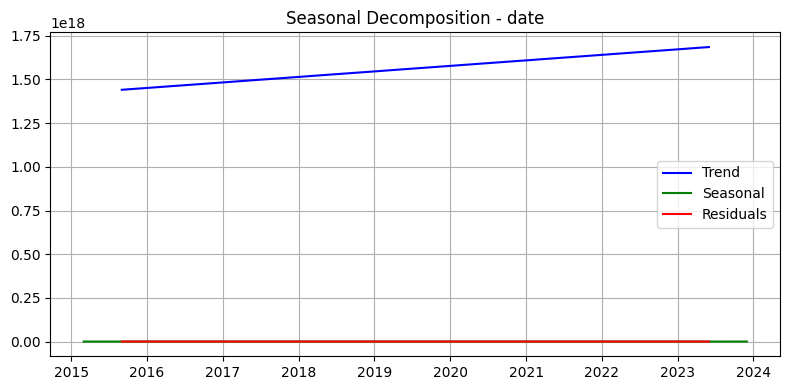

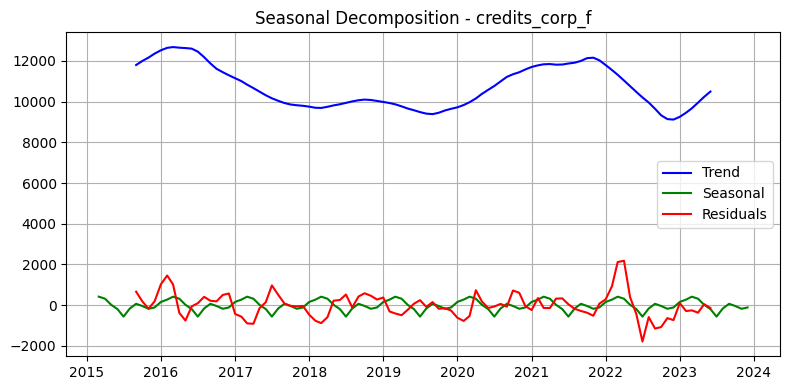

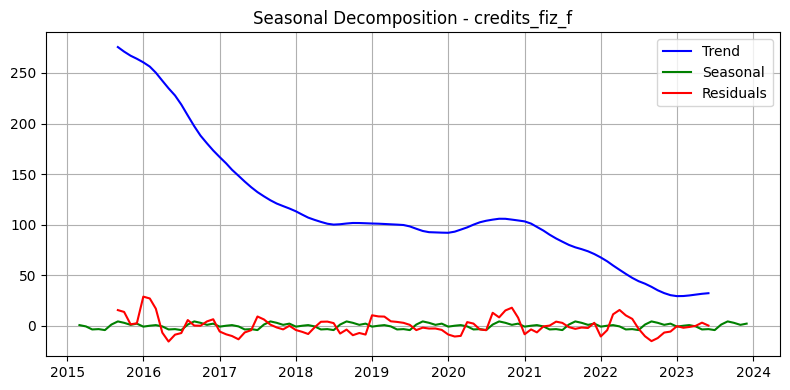

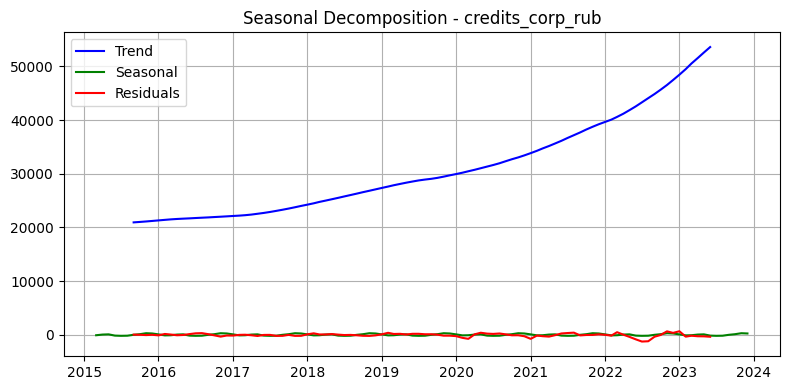

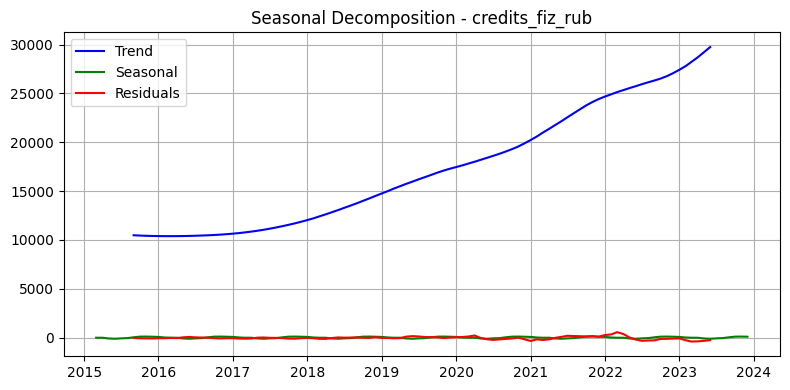

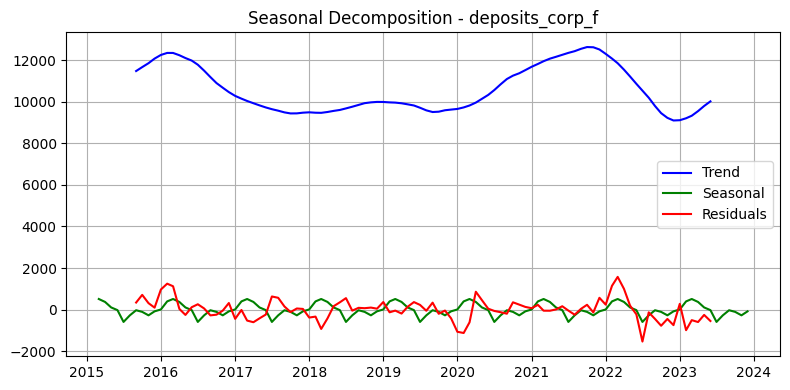

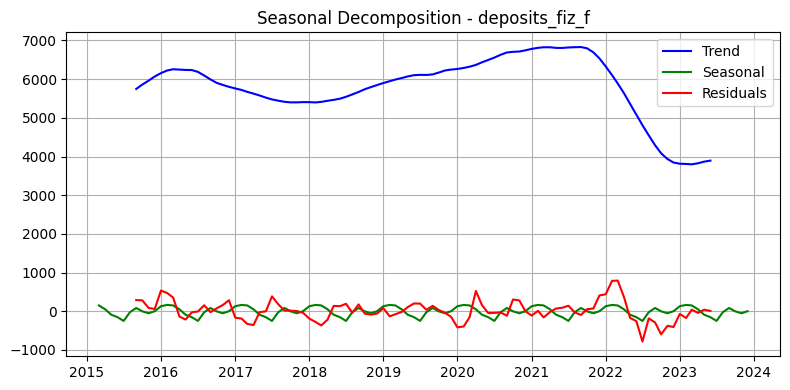

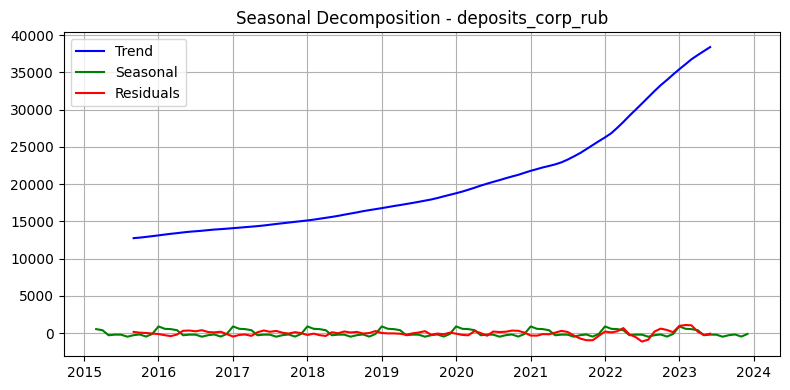

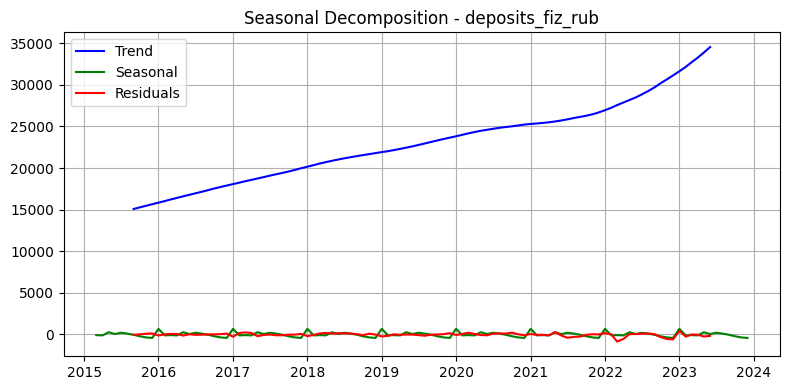

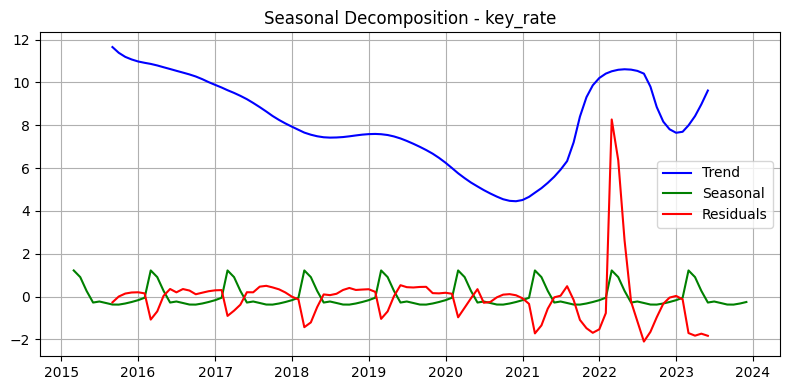

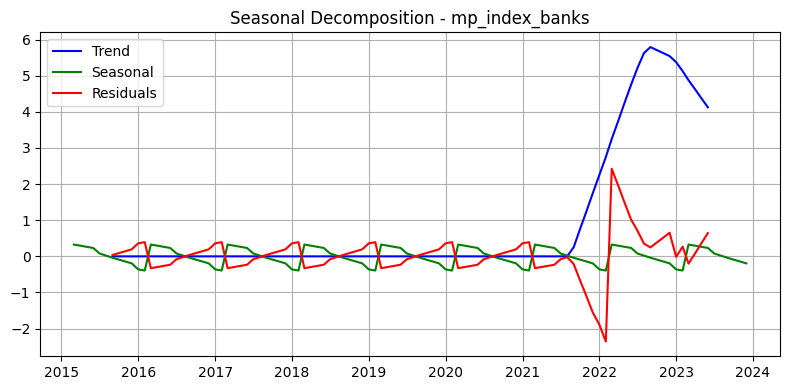

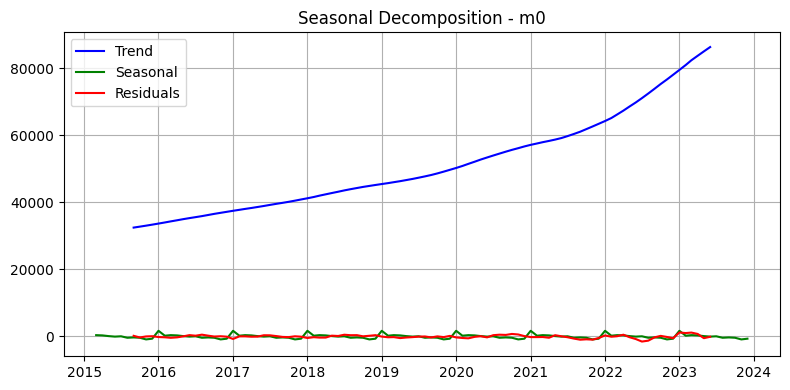

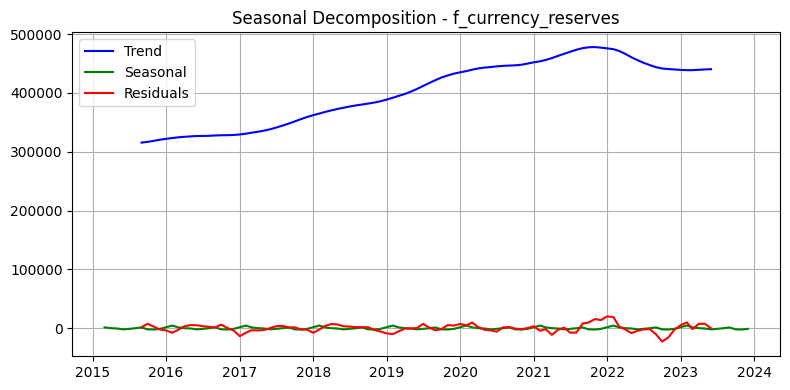

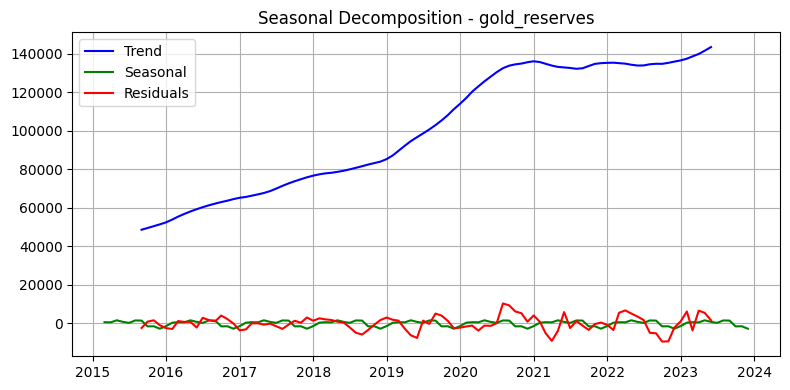

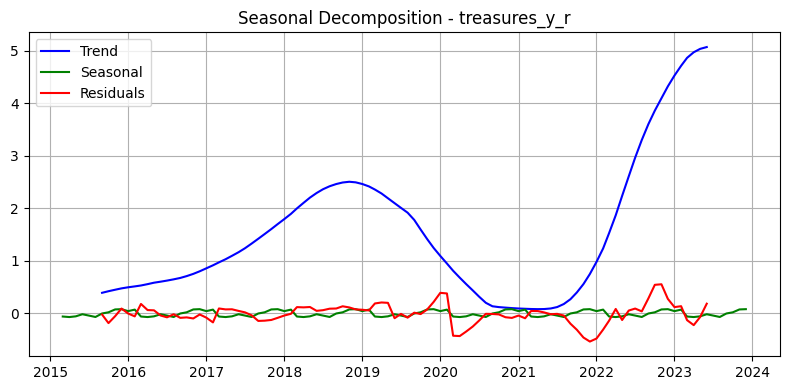

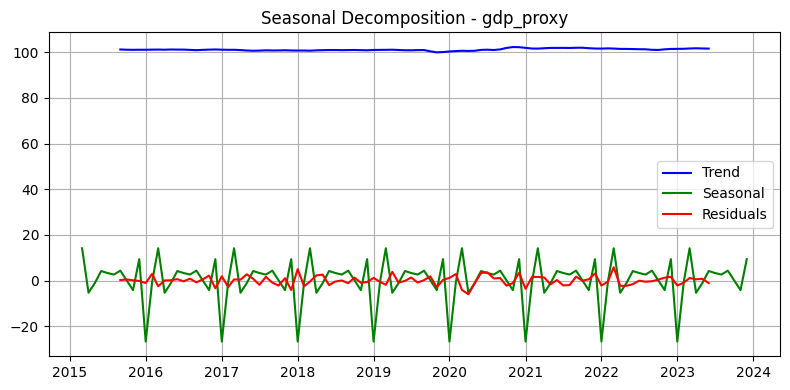

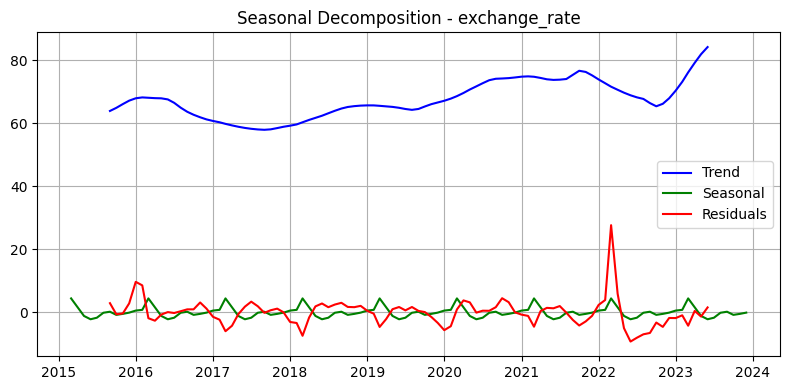

In [278]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def plot_seasonal_decomposition(dataframe):
    # Применяем seasonal_decompose к каждому столбцу в датафрейме
    for column in dataframe.columns:
        decomposition = seasonal_decompose(dataframe[column], model='additive', period=12)  # Используем аддитивную модель и период сезонности 12
        
        # Строим графики тренда, сезонности и остатков
        plt.figure(figsize=(8, 4))

        plt.plot(dataframe['date'], decomposition.trend, label='Trend', color='blue')
        plt.plot(dataframe['date'], decomposition.seasonal, label='Seasonal', color='green')
        plt.plot(dataframe['date'], decomposition.resid, label='Residuals', color='red')
        plt.title(f'Seasonal Decomposition - {column}')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
plot_seasonal_decomposition(result_for_banks)

In [267]:
from statsmodels.tsa.seasonal import seasonal_decompose

def remove_seasonality(dataframe):
    # Создаем копию датафрейма, чтобы избежать изменения исходных данных
    result_dataframe = dataframe.copy()
    
    # Применяем seasonal_decompose к каждому столбцу в датафрейме
    for column in dataframe.columns:
        if column != 'date':  # Пропускаем столбец с датами
            decomposition = seasonal_decompose(dataframe[column], model='additive', period=12)  # Используем аддитивную модель и период сезонности 12
            
            # Вычитаем сезонную компоненту из исходного значения
            result_dataframe[column] = dataframe[column] - decomposition.seasonal
            
    return result_dataframe


result_for_banks_no_s = remove_seasonality(result_for_banks)
result_for_banks_no_s.to_csv('/Users/svetlanamaslennikova/Desktop/диплом/данные/initial_banks.csv')
result_for_banks_no_s.head(1)

,date,credits_corp_f,credits_fiz_f,credits_corp_rub,credits_fiz_rub,deposits_corp_f,deposits_fiz_f,deposits_corp_rub,deposits_fiz_rub,key_rate,mp_index_banks,m0,f_currency_reserves,gold_reserves,treasures_y_r,gdp_proxy,exchange_rate
0,2015-03-01,10816.864365,315.53368,20612.617333,10786.131943,10902.723637,5039.084882,12414.362454,13965.489021,13.211599,-0.326389,30842.135479,311995.848896,46162.779266,0.311544,100.13185,56.02413


Стационарность

In [268]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_test(data):
    result_data = []

    for column in data.columns[1:]:
        indicator_name = column
        series = data[column]
        
        # ADF test
        adf_test_statistic, adf_p_value, _, _, _, _ = adfuller(series)
        adf_stationary = adf_p_value < 0.01
        
        # KPSS test
        kpss_test_statistic, kpss_p_value, _, _ = kpss(series)
        kpss_stationary = kpss_p_value > 0.01
        
        result_data.append({
            'Indicator': indicator_name,
            'adf_p_value': adf_p_value,
            'ADF Stationary': adf_stationary,
            'kpss_p_value': kpss_p_value,
            'KPSS Stationary': kpss_stationary
        })
    
    result_df = pd.DataFrame(result_data)
    return result_df



In [282]:
stationarity_test(result_for_banks_no_s)

,Indicator,adf_p_value,ADF Stationary,kpss_p_value,KPSS Stationary
0,credits_corp_f,7.831534e-02,False,0.100000,True
1,credits_fiz_f,4.074509e-02,False,0.010000,False
2,credits_corp_rub,1.000000e+00,False,0.010000,False
3,credits_fiz_rub,1.000000e+00,False,0.010000,False
4,deposits_corp_f,3.443815e-02,False,0.100000,True
5,deposits_fiz_f,6.422785e-01,False,0.100000,True
6,deposits_corp_rub,1.000000e+00,False,0.010000,False
7,deposits_fiz_rub,9.986125e-01,False,0.010000,False
8,key_rate,1.381662e-01,False,0.071408,True
9,mp_index_banks,6.135127e-01,False,0.010000,False


In [269]:
import warnings
warnings.filterwarnings("ignore")
stationary_test_banks = stationarity_test(result_for_banks_no_s)
stationary_test_banks.to_csv('result_for_banks_stat.csv')
non_stat_ind = stationary_test_banks[(stationary_test_banks['ADF Stationary']== False) | (stationary_test_banks['KPSS Stationary']== False) ]['Indicator'
]
non_stat_ind

0          credits_corp_f
1           credits_fiz_f
2        credits_corp_rub
3         credits_fiz_rub
4         deposits_corp_f
5          deposits_fiz_f
6       deposits_corp_rub
7        deposits_fiz_rub
8                key_rate
9          mp_index_banks
10                     m0
11    f_currency_reserves
12          gold_reserves
13          treasures_y_r
15          exchange_rate
Name: Indicator, dtype: object

In [270]:
result_for_banks_no_s_prep = result_for_banks_no_s.copy()
for col in non_stat_ind:
    result_for_banks_no_s_prep[col] = result_for_banks_no_s[col].diff()



result_for_banks_no_s_prep.replace([np.inf, -np.inf], np.nan, inplace=True)
result_for_banks_no_s_prep.fillna(0, inplace=True)
stationary_test_banks = stationarity_test(result_for_banks_no_s_prep)
stationary_test_banks.to_csv('result_for_banks_stat_3.csv')
non_stat_ind = stationary_test_banks[(stationary_test_banks['ADF Stationary']== False) | (stationary_test_banks['KPSS Stationary']== False) ]['Indicator'
]
non_stat_ind

2      credits_corp_rub
3       credits_fiz_rub
6     deposits_corp_rub
7      deposits_fiz_rub
10                   m0
Name: Indicator, dtype: object

# Рисовалки

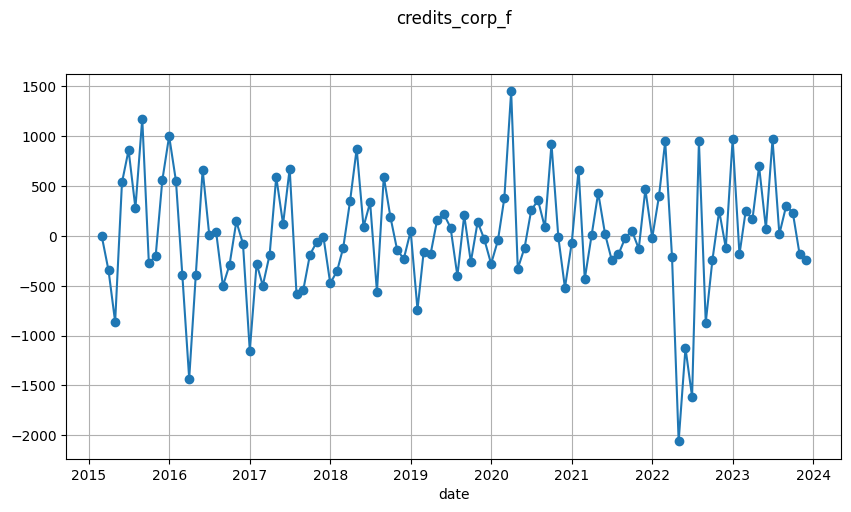

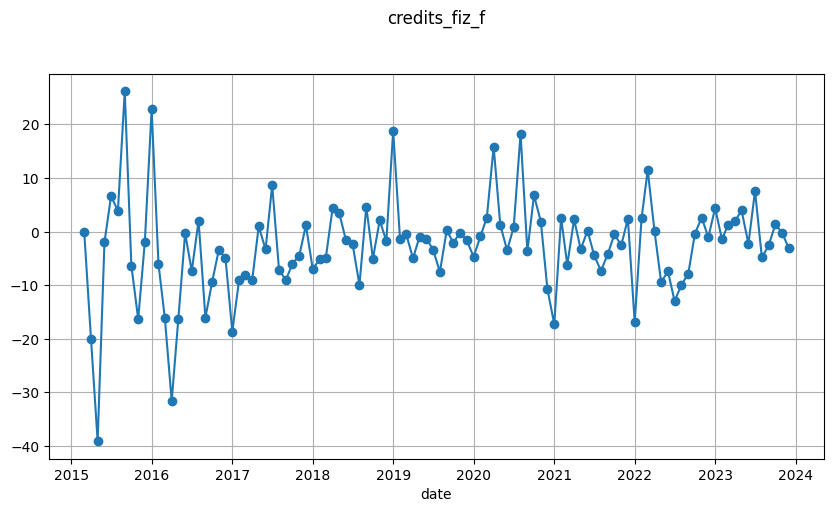

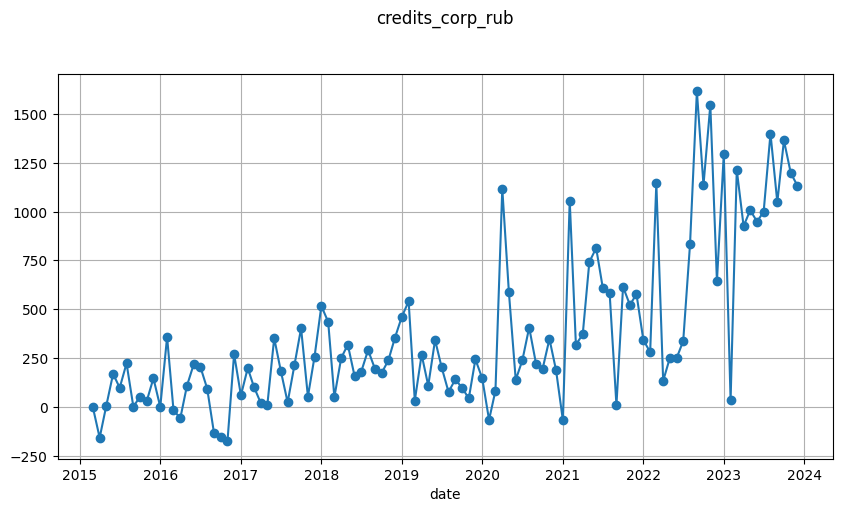

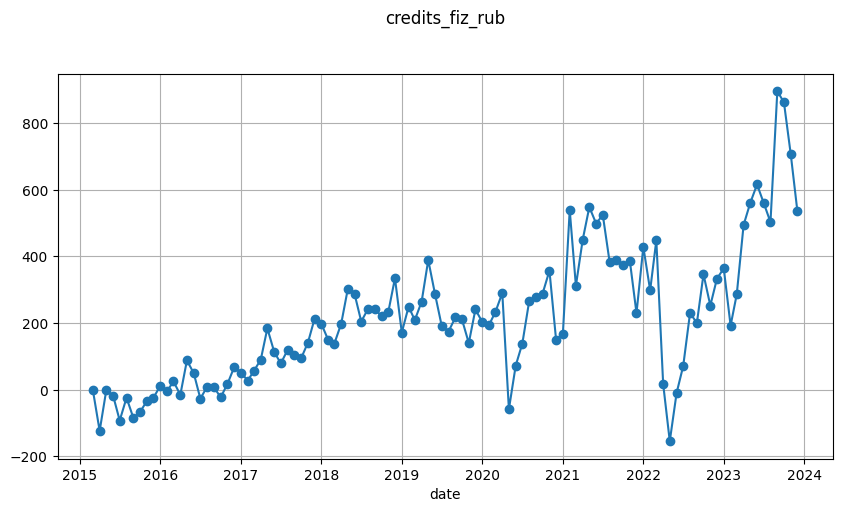

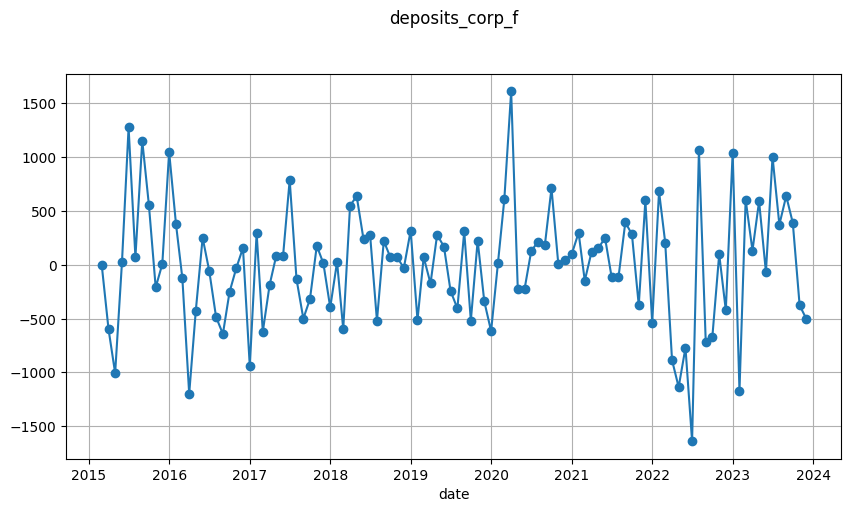

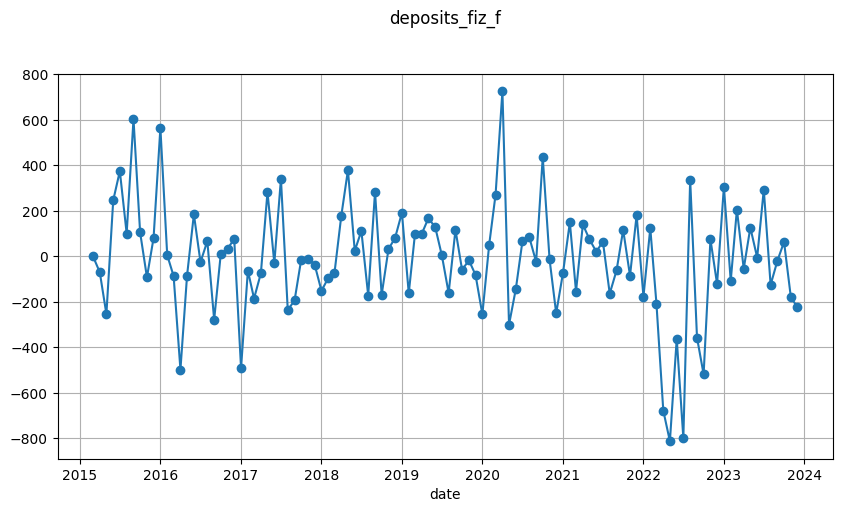

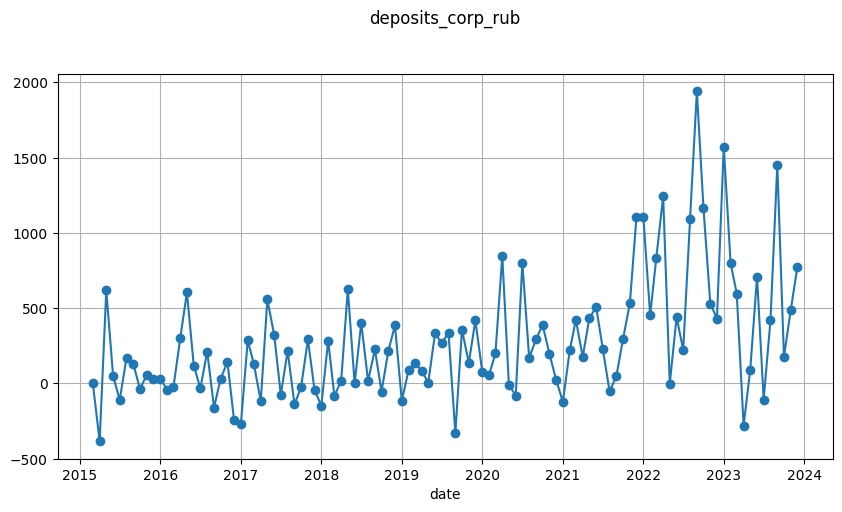

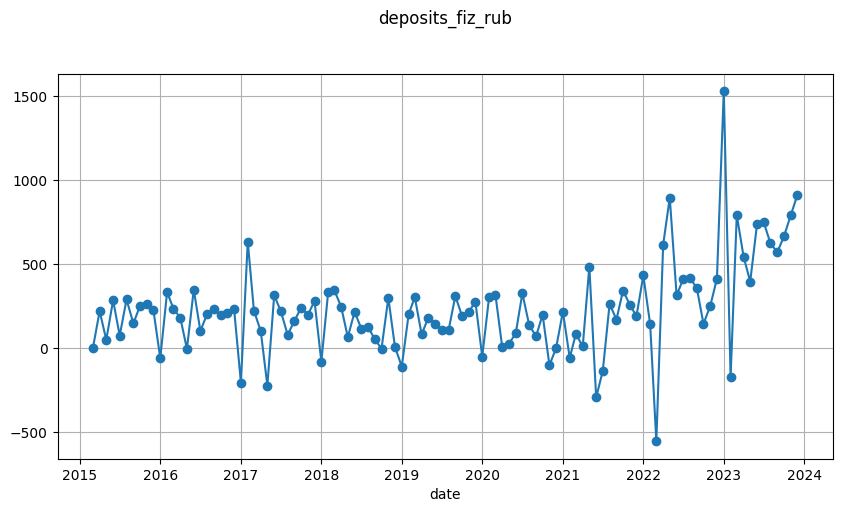

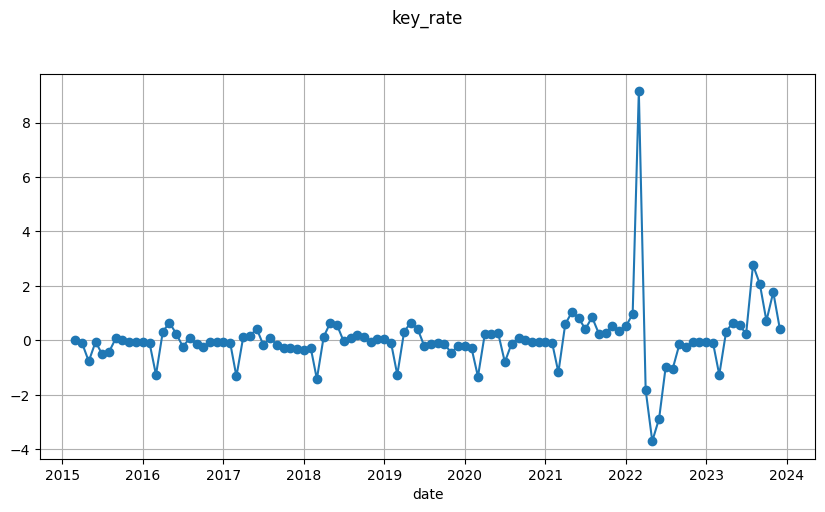

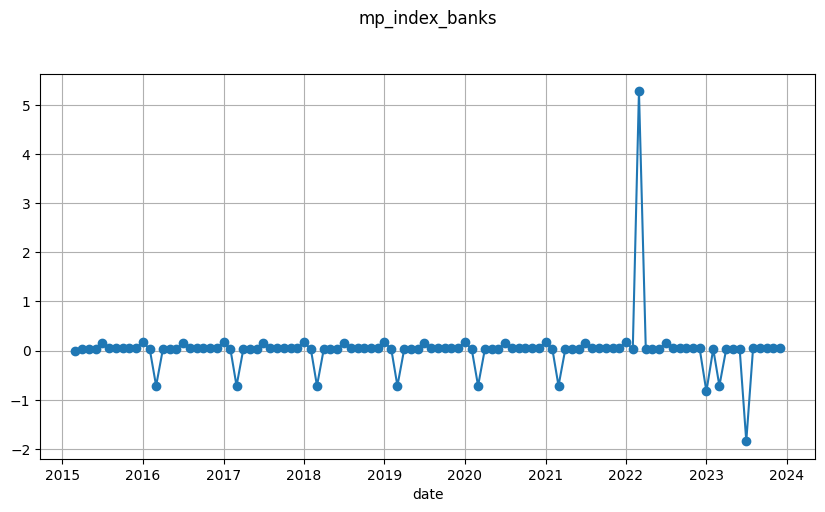

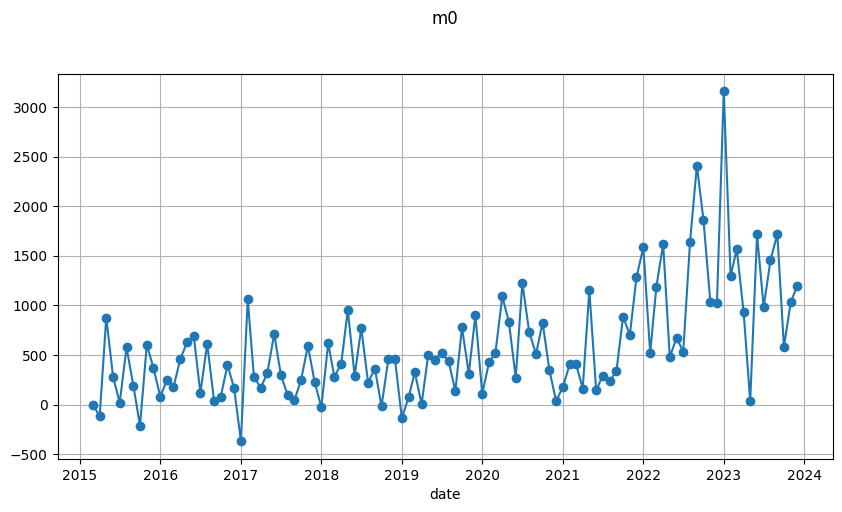

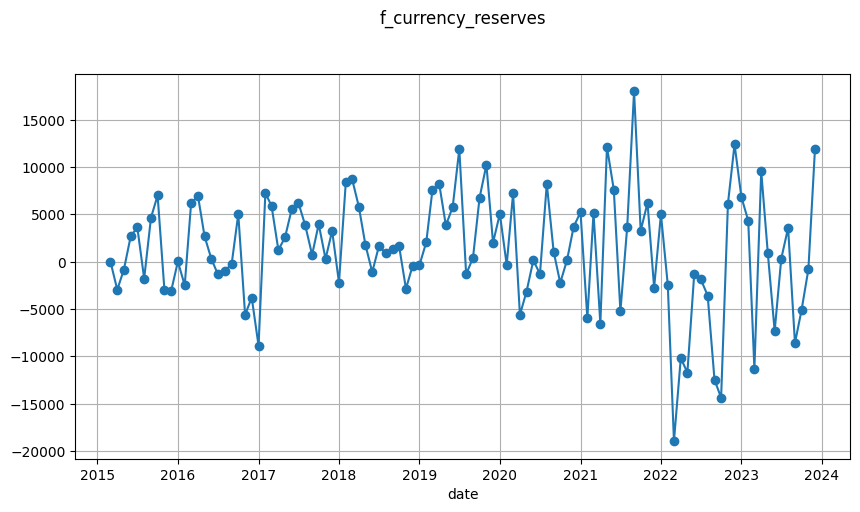

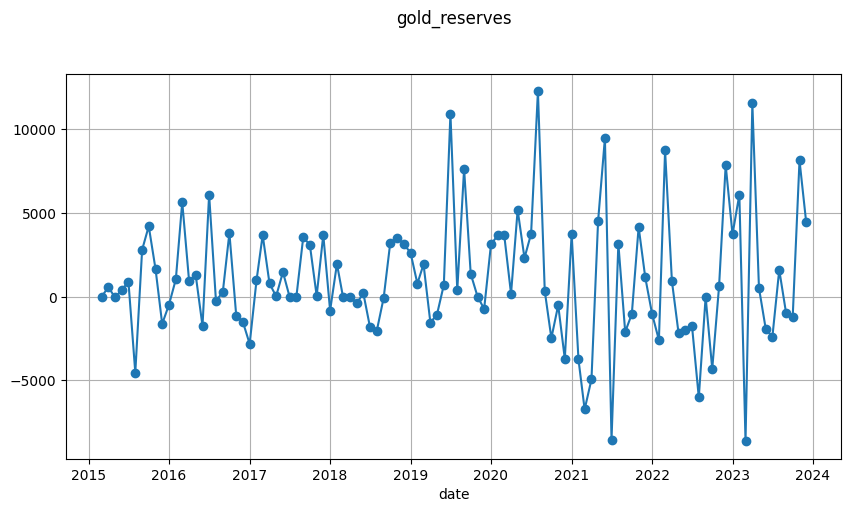

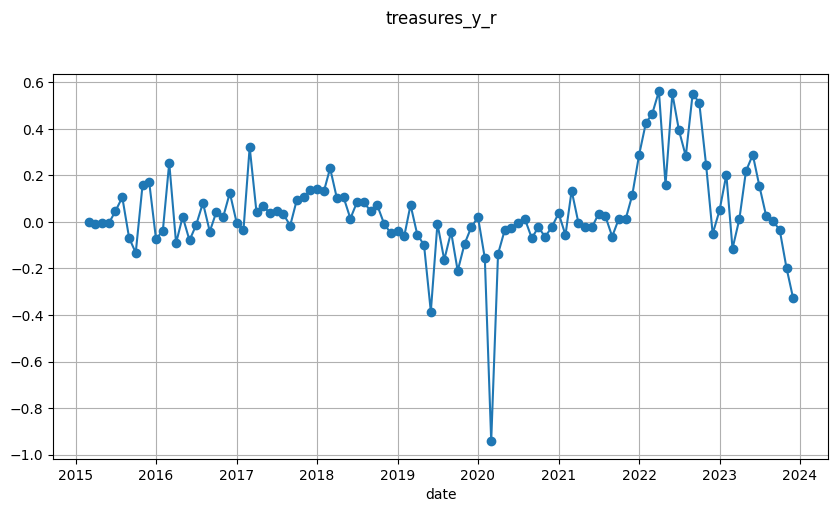

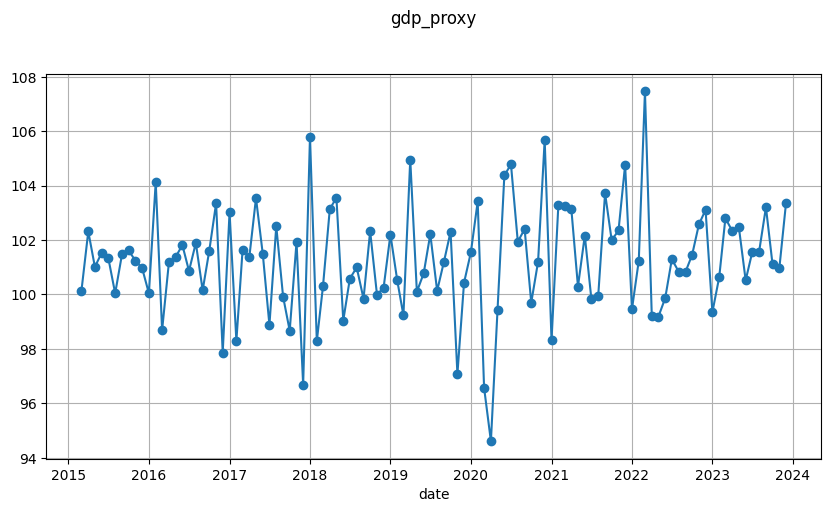

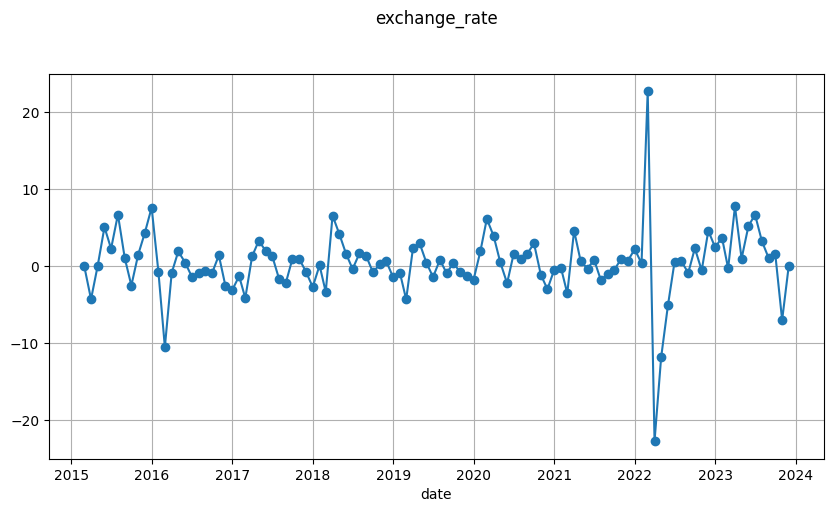

In [271]:
import matplotlib.pyplot as plt

def plot_time_series(df):
    # Устанавливаем дату как индекс
    data = df.copy()
    data.set_index('date', inplace=True)
    
    # Построение графиков для каждого показателя
    for i in range(len(data.columns)):
        plt.figure(figsize=(10, 5))
        plt.plot(data.index, data[data.columns[i]], marker='o', linestyle='-')
        plt.title(data.columns[i] + '\n' + '\n')
        plt.xlabel('date')
        plt.grid(True)
        plt.show()


plot_time_series(result_for_banks_no_s_prep)


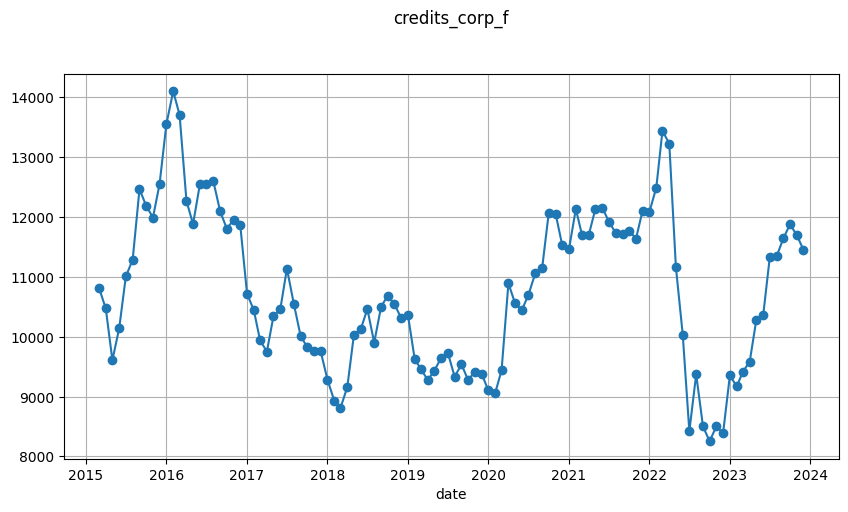

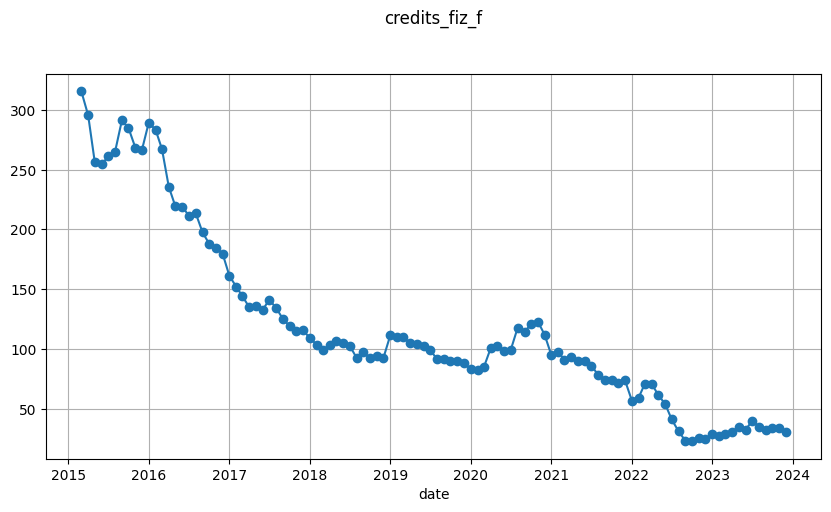

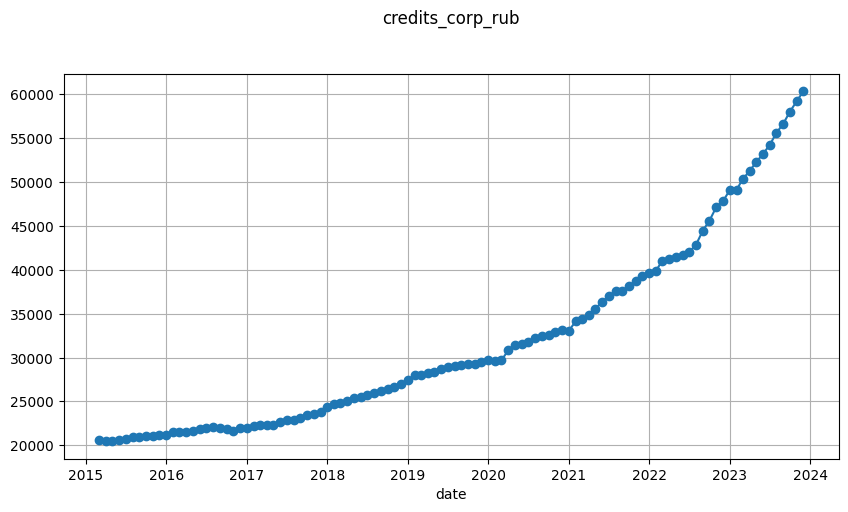

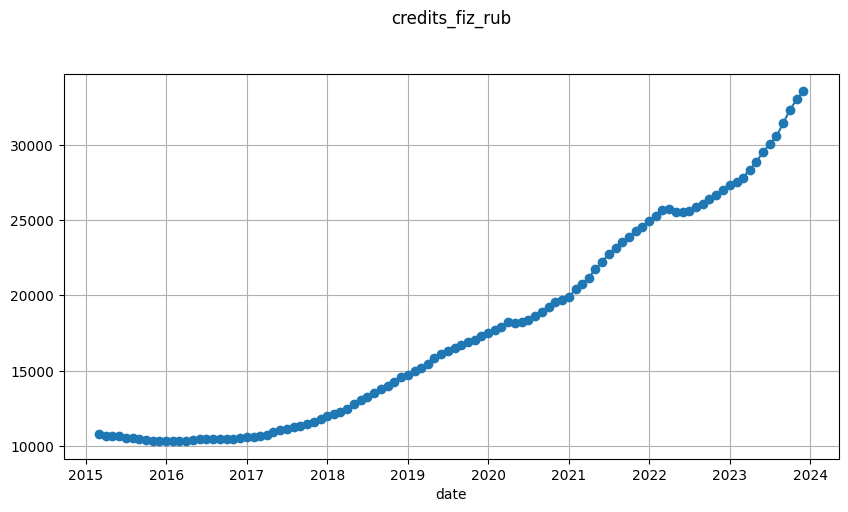

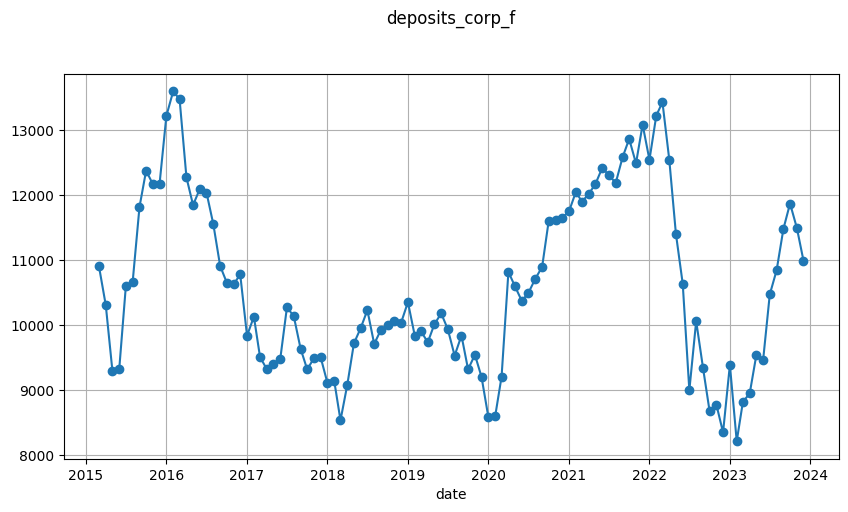

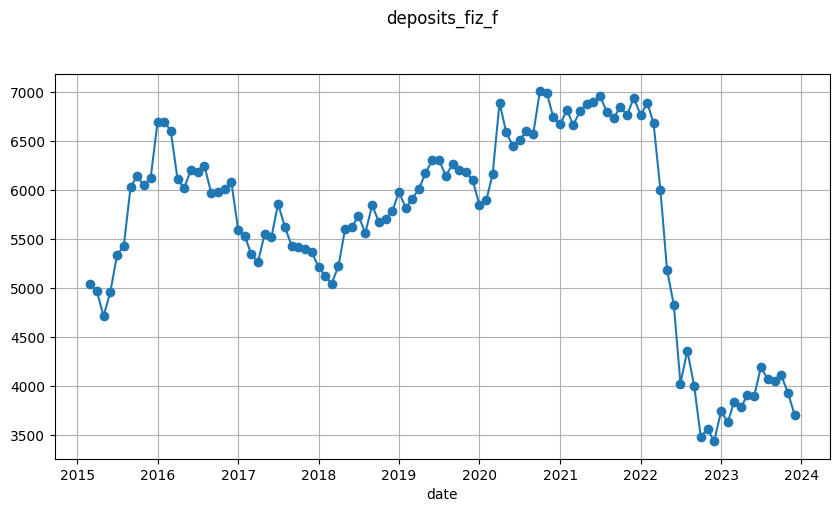

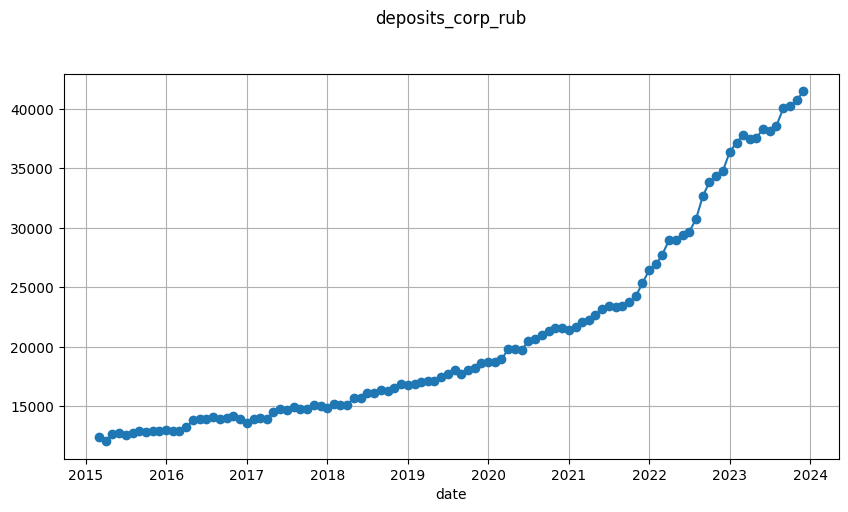

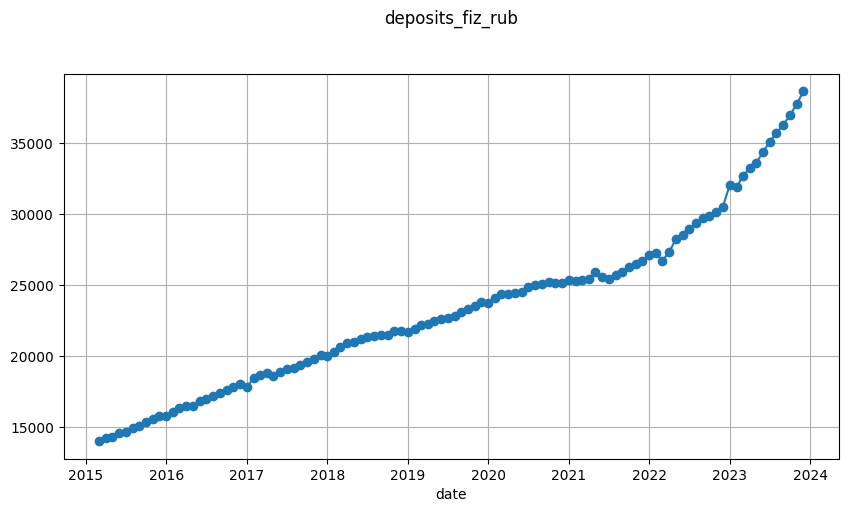

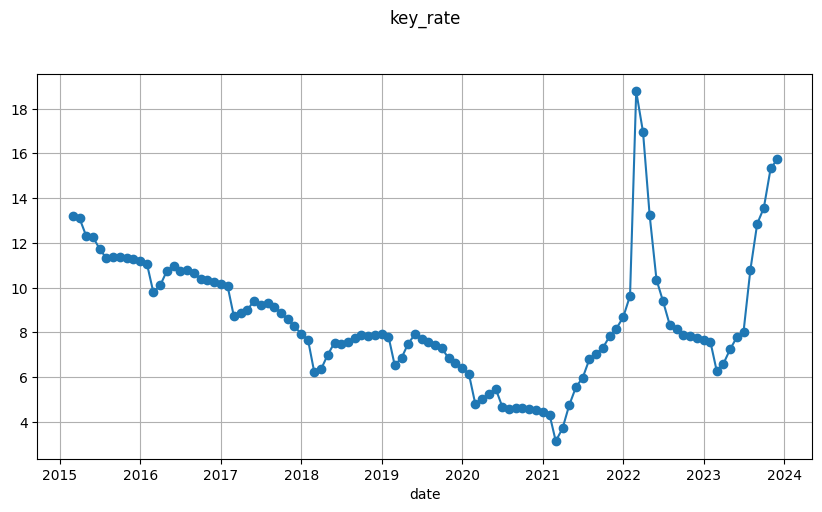

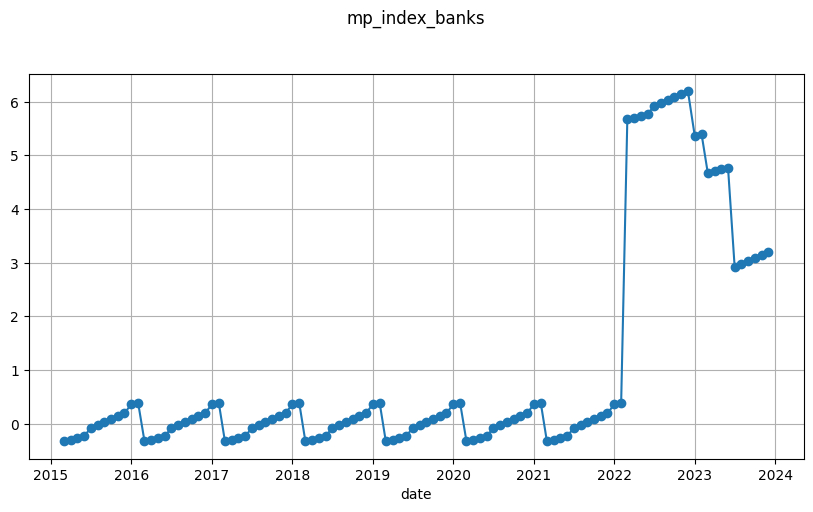

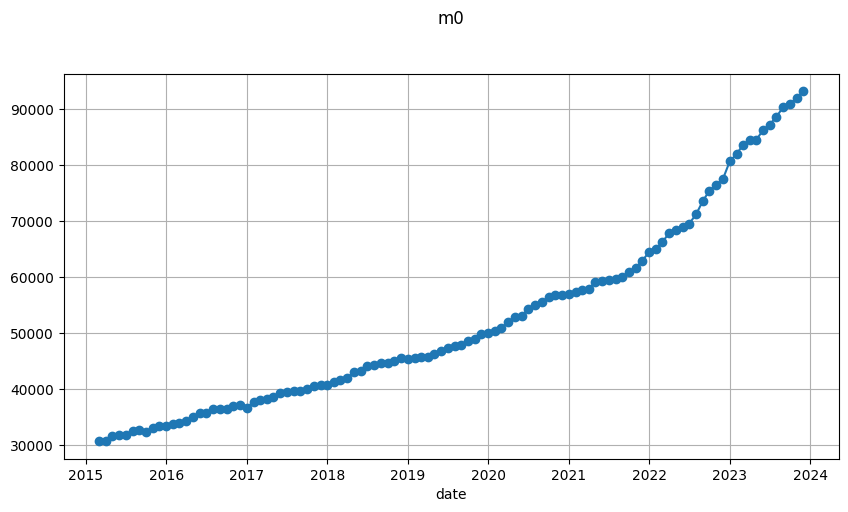

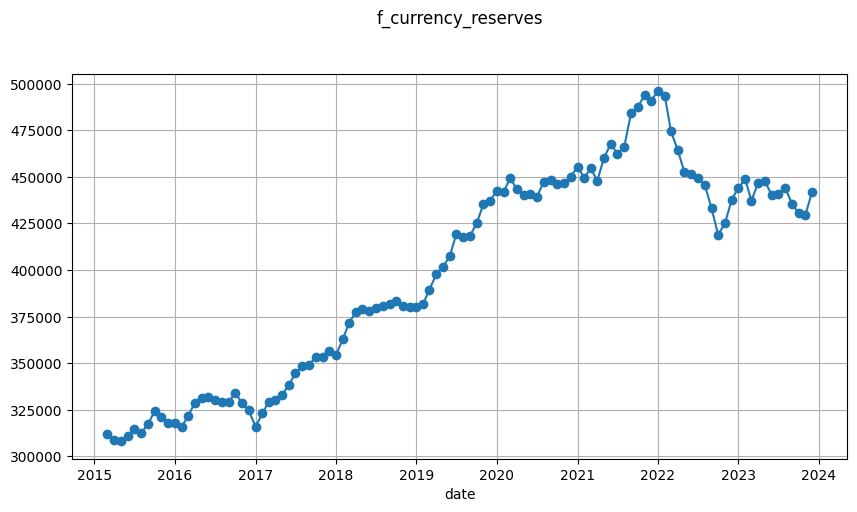

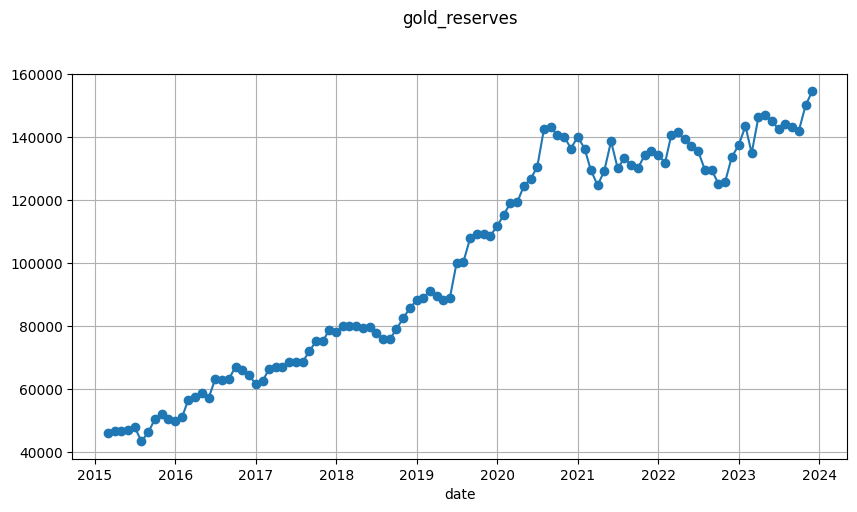

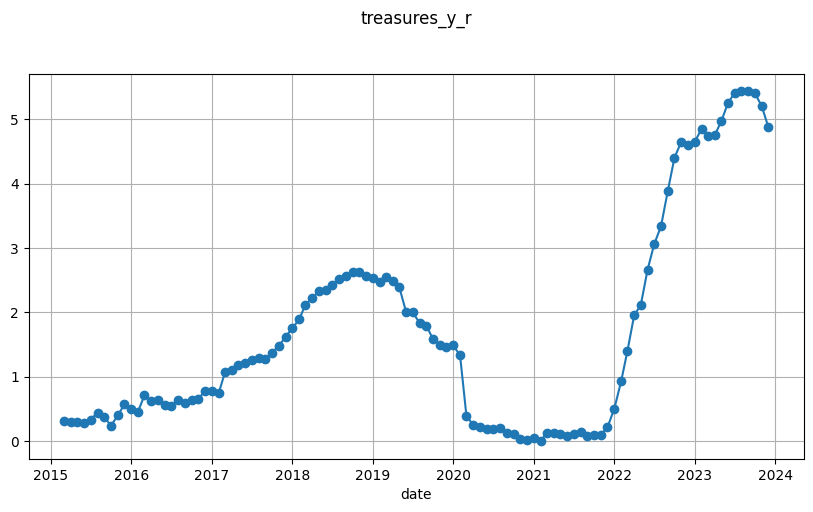

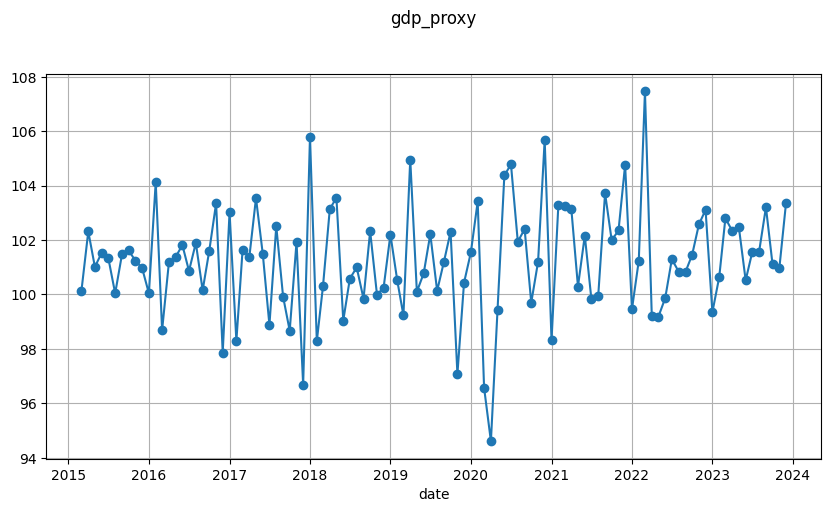

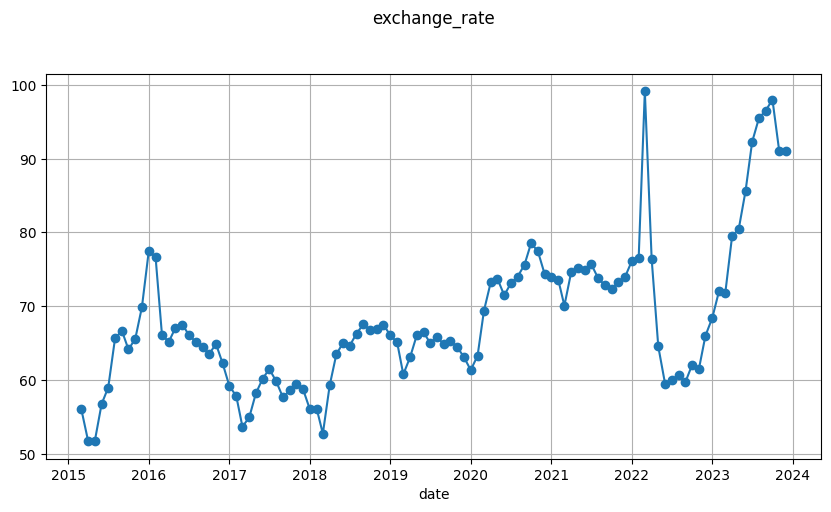

In [283]:
plot_time_series(result_for_banks_no_s)


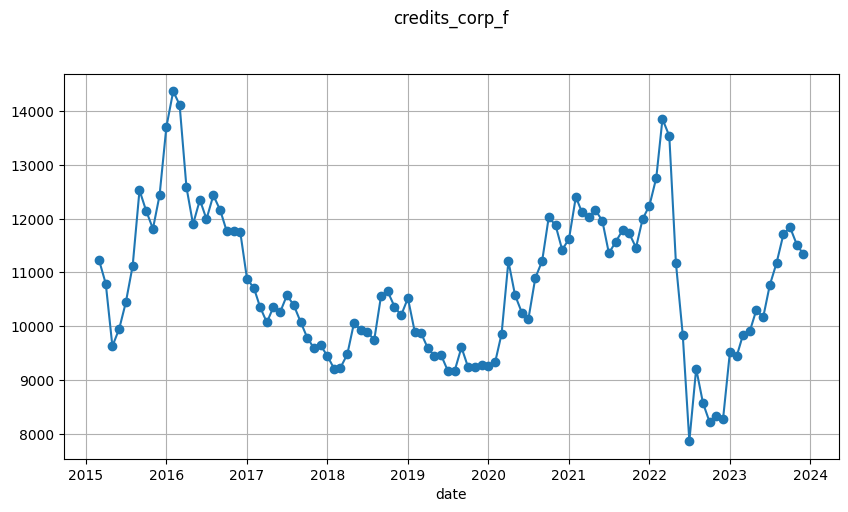

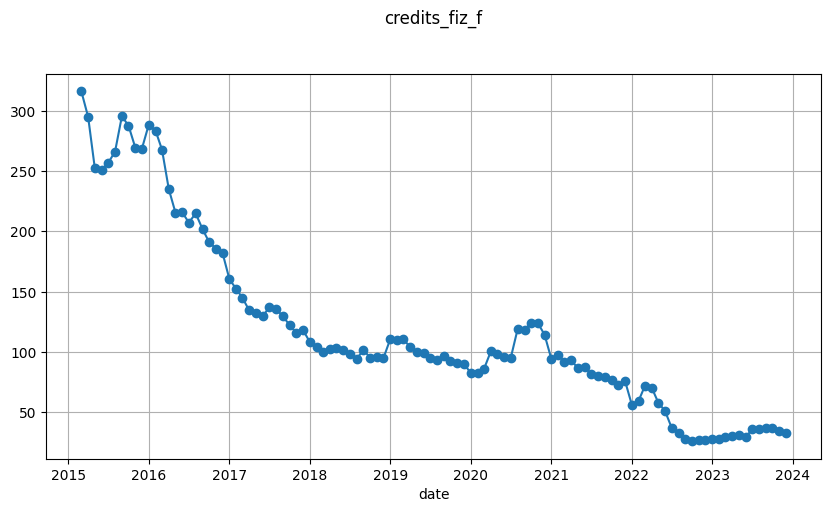

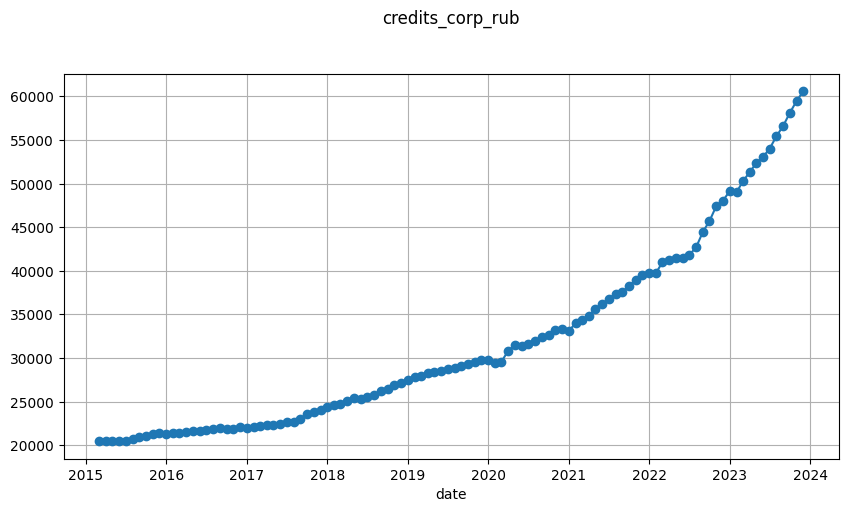

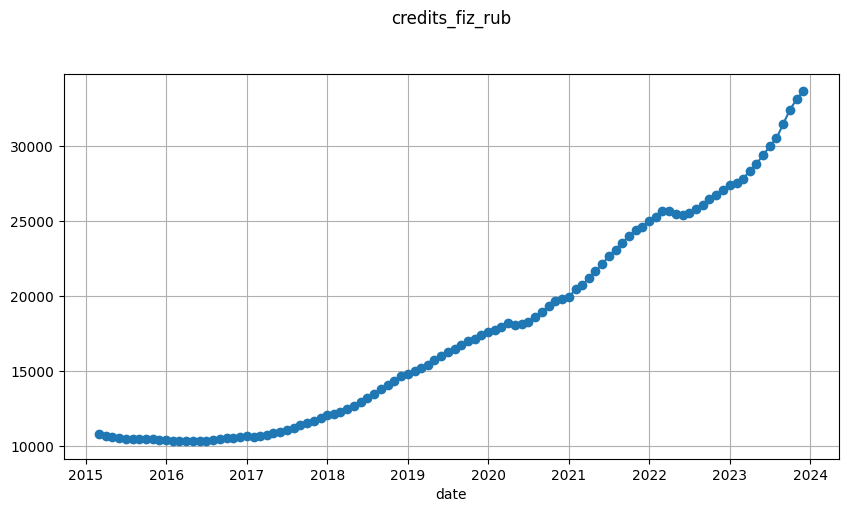

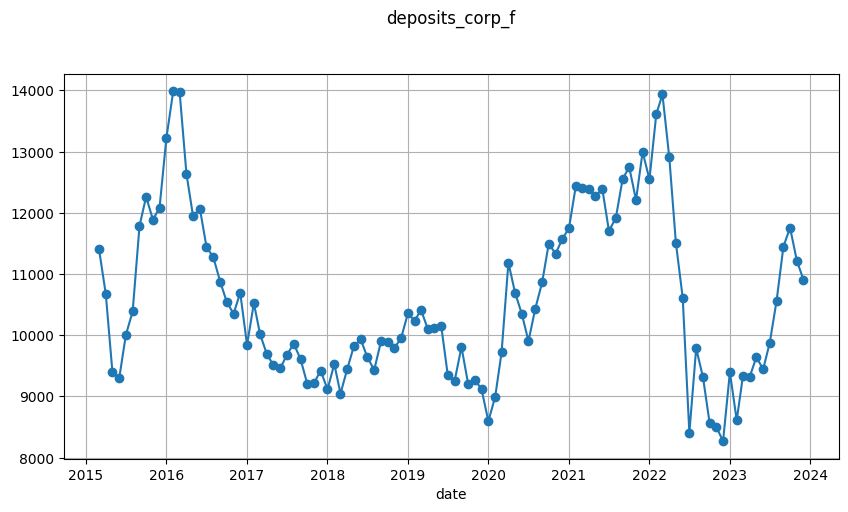

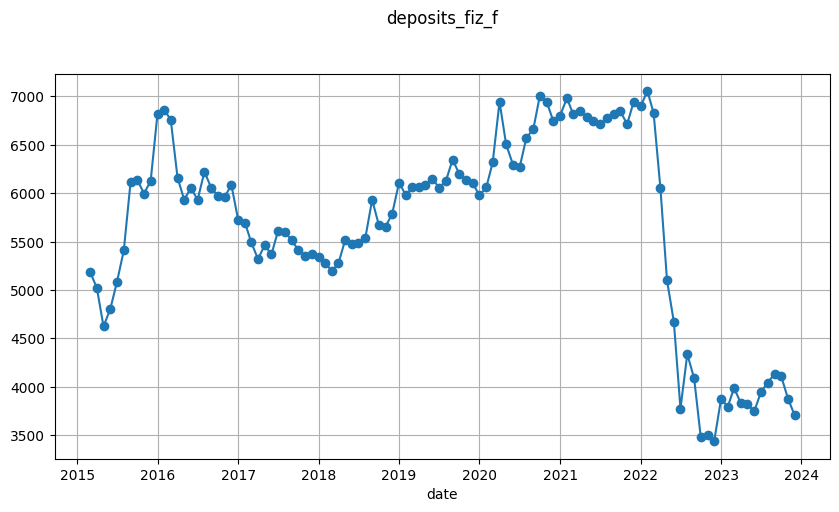

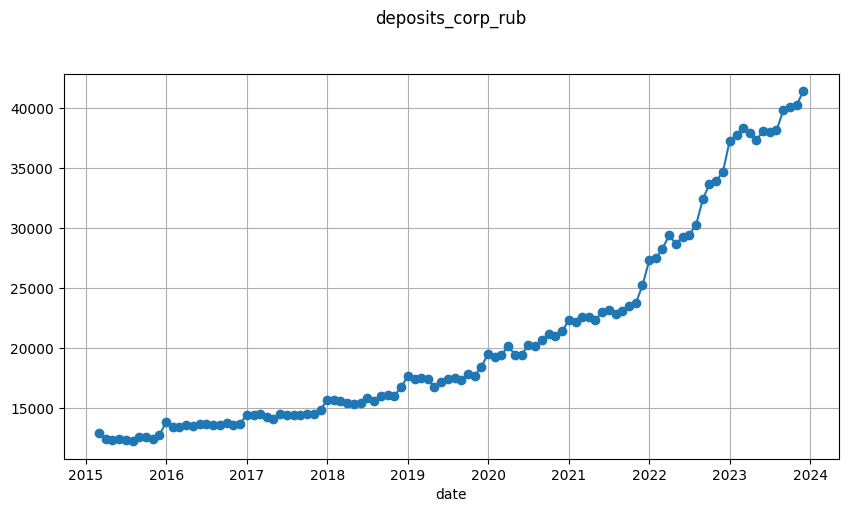

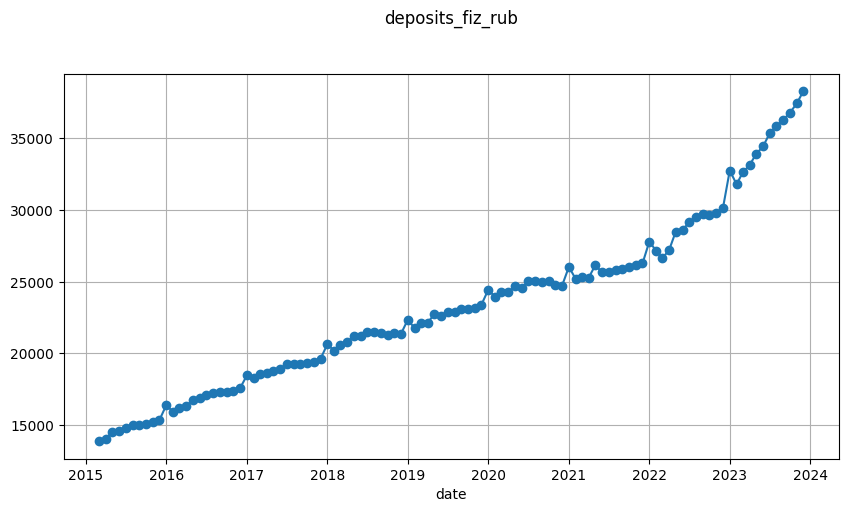

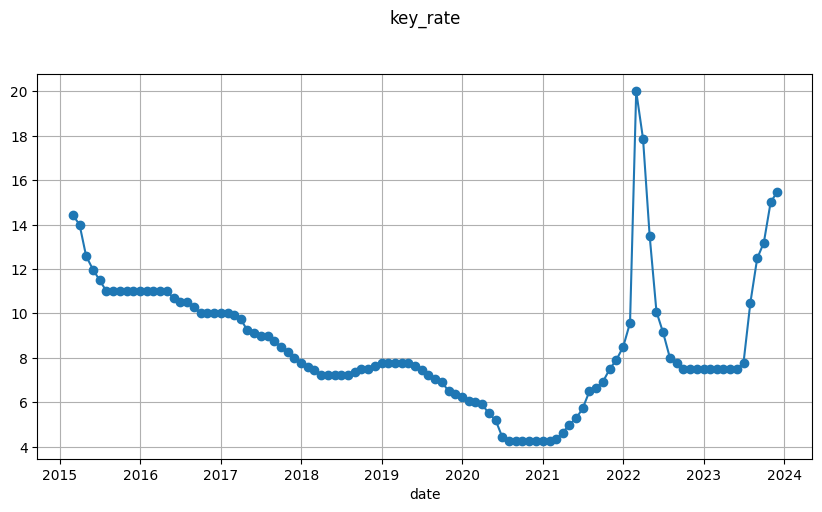

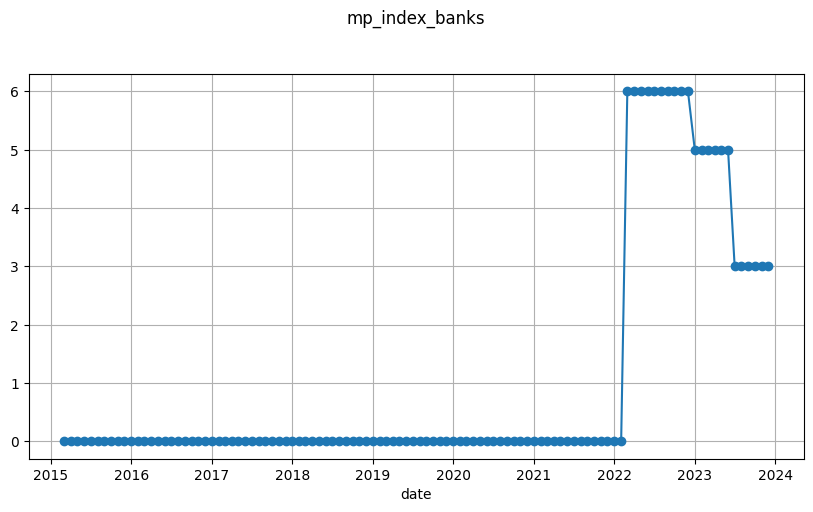

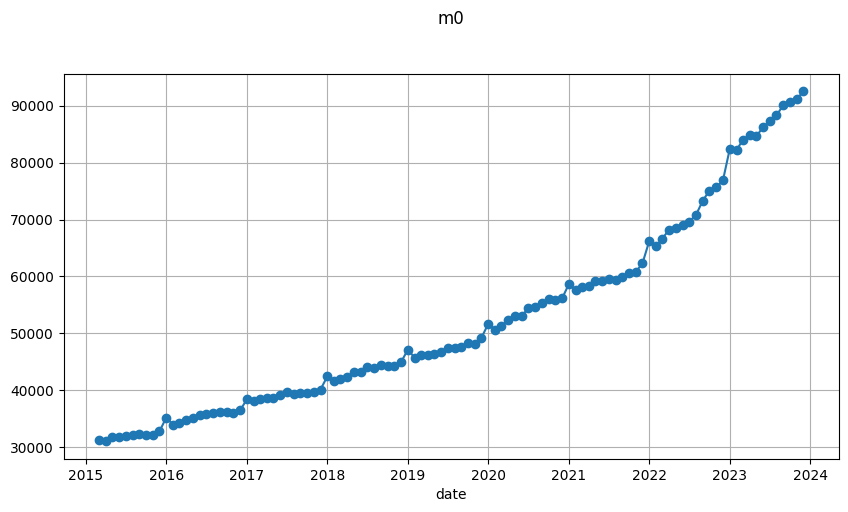

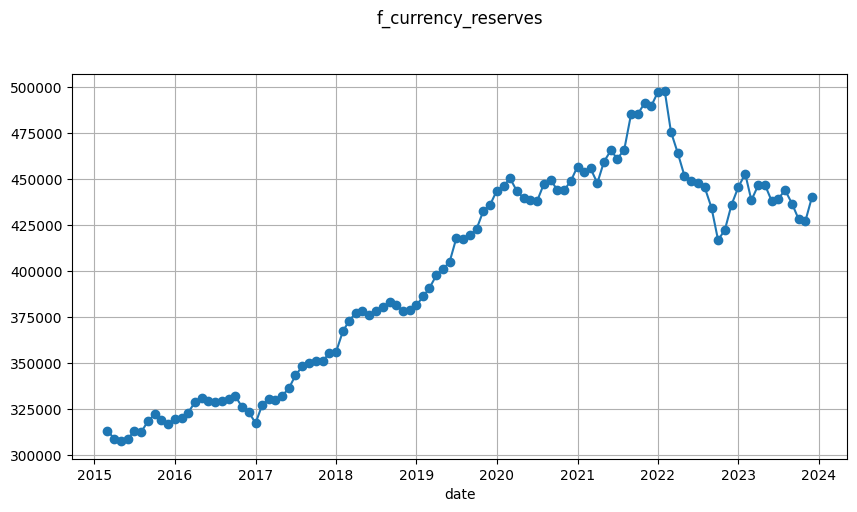

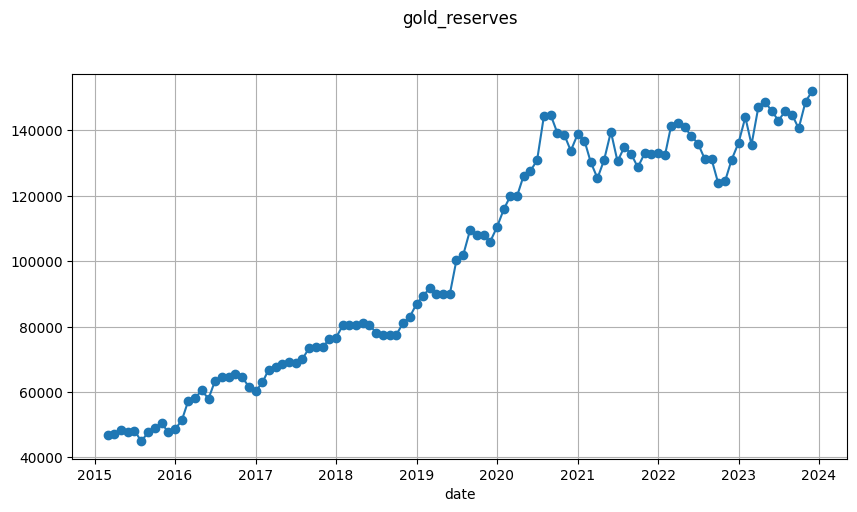

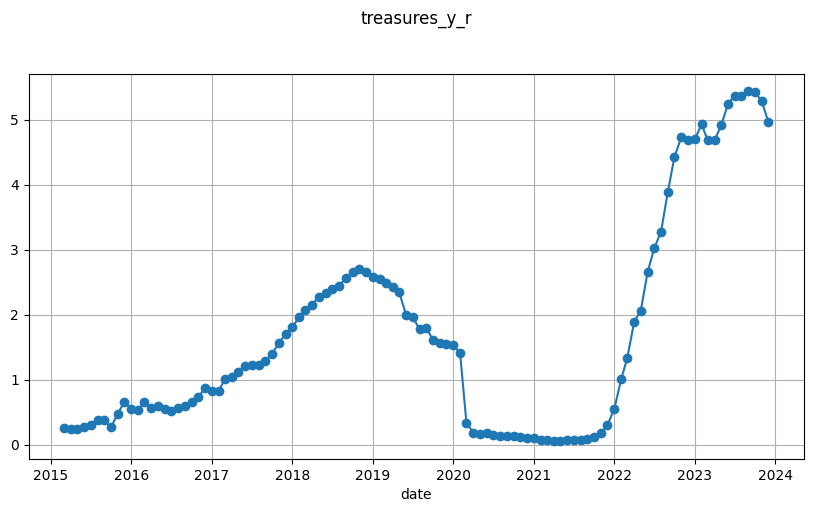

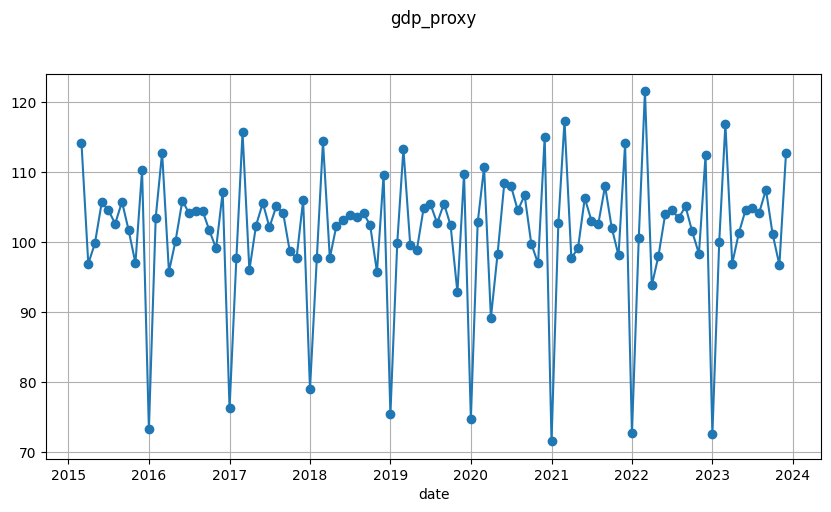

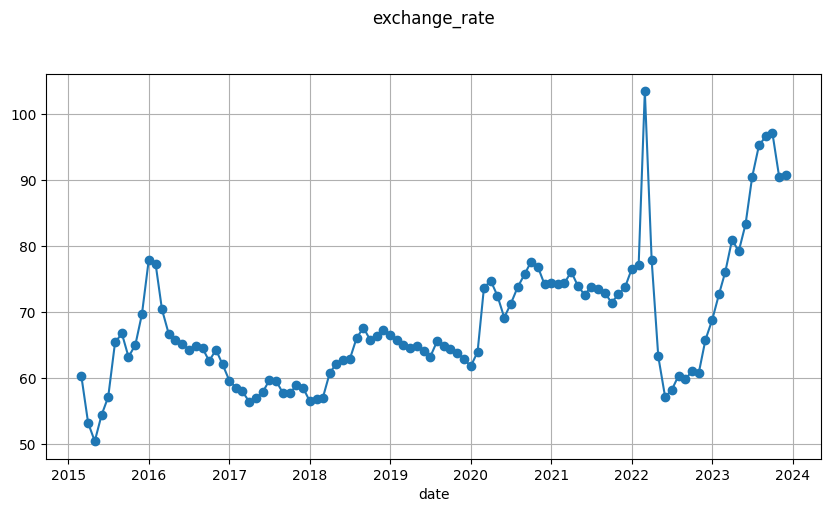

In [279]:
plot_time_series(result_for_banks)


In [276]:
exog_short = result_for_banks_no_s_prep[['date', 'key_rate', 'exchange_rate', 'treasures_y_r', 'm0', 'gdp_proxy']]
exog_ext = result_for_banks_no_s_prep[['date', 'key_rate', 'exchange_rate', 'treasures_y_r', 'gdp_proxy', 'm0',
                             'mp_index_banks', 
                       'f_currency_reserves', 'gold_reserves']]
endog_banks = result_for_banks_no_s_prep[['date', 'credits_corp_f', 'credits_fiz_f', 'credits_corp_rub',
           'credits_fiz_rub', 'deposits_corp_f', 'deposits_fiz_f',
           'deposits_corp_rub', 'deposits_fiz_rub']]

exog_short.to_csv('/Users/svetlanamaslennikova/Desktop/диплом/данные/exog_short.csv')
exog_ext.to_csv('/Users/svetlanamaslennikova/Desktop/диплом/данные/exog_ext.csv')
endog_banks.to_csv('/Users/svetlanamaslennikova/Desktop/диплом/данные/endog_banks.csv')


In [277]:
exog_short

,date,key_rate,exchange_rate,treasures_y_r,m0,gdp_proxy
0,2015-03-01,0.000000,0.000000,0.000000,0.000000,100.131850
1,2015-04-01,-0.116804,-4.315343,-0.010144,-118.927083,102.311522
2,2015-05-01,-0.778872,-0.013941,-0.006094,876.447917,101.007806
3,2015-06-01,-0.057433,5.036593,-0.005575,277.500000,101.530953
4,2015-07-01,-0.525110,2.239019,0.046590,18.096726,101.330796
...,...,...,...,...,...,...
101,2023-08-01,2.762409,3.235285,0.024368,1455.946429,101.568291
102,2023-09-01,2.070056,1.009118,0.002208,1719.284970,103.200171
103,2023-10-01,0.708448,1.497006,-0.033824,581.390625,101.099853
104,2023-11-01,1.766486,-7.022781,-0.197836,1033.723958,100.975967
